In [97]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import pybedtools
import seaborn as sns
from pybedtools import BedTool
import sys
from tqdm import tqdm

import sys; sys.path.insert(0, "/storage/group/izg5139/default/nicole/g4_t2t_identification/scripts")
from dotenv import load_dotenv
loaded = load_dotenv("/storage/group/izg5139/default/nicole/g4_t2t_identification/scripts/.env")
print(loaded)
from constants import ConfigPaths
import pandas as pd
from pybedtools import BedTool
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

True


In [100]:
import dask.dataframe as dd

controls_regex = dd.read_csv("/storage/group/izg5139/default/nicole/g4_t2t_identification/scripts/gc_content_controls_new/*.bed", sep="\t").compute().query("seqID != 'chrY'")
controls_regex

,seqID,start,end,sequence,controls_for,length,gc_content,cg_counts,gc_counts
0,chr1,3333,3354,gggtggagcgttgtaggcaga,cccaaattccctccccaaccc,21,13,1,2
1,chr1,3547,3574,cctgctggcgccggggcactgcagggc,gggtggcgggggtggggtggggagggg,27,22,2,6
2,chr1,4454,4473,cccgccatcccaggcacgc,ccctgcacccacccacccc,19,15,2,3
3,chr1,5945,5972,ctggtgcaccccttgctccccttccgc,ggggtgggaccaaaggggcgtctaggg,27,19,1,3
4,chr1,10639,10666,gggggcagcccactcacagtggccctg,ccccctacctggcccacccaactcccc,27,20,0,3
...,...,...,...,...,...,...,...,...,...
28386,chrX,154244715,154244746,cctcaccgcggacgccgccccaggtgtcccc,gggggaggggagggggaggggagggaggggg,31,25,4,3
28387,chrX,154249103,154249125,ggcccaccccgcaccagggagg,ggggtcgggggagtggggaggg,22,18,1,2
28388,chrX,154255480,154255510,ccctgcagtgccccggcgccagcagggggc,cccccgcctcccaccgtccccacggcgccc,30,25,2,6
28389,chrX,154255487,154255517,gtgccccggcgccagcagggggcggtggcc,ccccccaccagcccgcccccccctcccccc,30,26,3,6


In [101]:
controls_regex_bed = BedTool.from_dataframe(controls_regex).sort()

In [102]:
controls_regex_bed.intersect(regex_bed).count()

0

In [103]:
controls_regex_df = pd.read_table(controls_regex_bed.intersect(g4_bed, v=True).fn,
                                  header=None,
                                  names=list(controls_regex.columns)
                                 )
controls_regex_df_bed = BedTool.from_dataframe(controls_regex_df).sort()
controls_regex_df

,seqID,start,end,sequence,controls_for,length,gc_content,cg_counts,gc_counts
0,chr1,3333,3354,gggtggagcgttgtaggcaga,cccaaattccctccccaaccc,21,13,1,2
1,chr1,3547,3574,cctgctggcgccggggcactgcagggc,gggtggcgggggtggggtggggagggg,27,22,2,6
2,chr1,4454,4473,cccgccatcccaggcacgc,ccctgcacccacccacccc,19,15,2,3
3,chr1,10639,10666,gggggcagcccactcacagtggccctg,ccccctacctggcccacccaactcccc,27,20,0,3
4,chr1,12777,12794,cggcaccaggtggcagc,ccctccctcccttcccc,17,13,1,3
...,...,...,...,...,...,...,...,...,...
582099,chrX,154244296,154244323,gcctgggtgacagagcgagacgccgtc,cccttctcccttcctccctcctccccc,27,19,3,3
582100,chrX,154249103,154249125,ggcccaccccgcaccagggagg,ggggtcgggggagtggggaggg,22,18,1,2
582101,chrX,154255480,154255510,ccctgcagtgccccggcgccagcagggggc,cccccgcctcccaccgtccccacggcgccc,30,25,2,6
582102,chrX,154255487,154255517,gtgccccggcgccagcagggggcggtggcc,ccccccaccagcccgcccccccctcccccc,30,26,3,6


In [104]:
controls_regex_df_bed.intersect(g4_bed).count(), controls_regex_df_bed.intersect(regex_bed).count()

(0, 0)

In [105]:
controls_regex_df_bed.intersect(control_bed).count()

252476

In [106]:
# load g4hunter
regex_df = pd.read_table(ConfigPaths.G4REGEX.value)
regex_bed = BedTool.from_dataframe(regex_df).sort()

# load control group
# control_df = pd.read_table(ConfigPaths.CONTROL_G4REGEX.value)
control_bed = BedTool.from_dataframe(controls_regex_df).sort()

genome_size = pd.read_table(ConfigPaths.GENOME_SIZE.value, header=None)[1].sum()

# test validity of control group
g4_gw_density = pd.read_table(
                            controls_regex_df.sort().merge().fn, 
                            header=None, 
                            names=["seqID", "start", "end"]
)
g4_gw_density["size"] = g4_gw_density["end"] - g4_gw_density["start"]
g4_gw_density = g4_gw_density["size"].sum() * 1e6 / genome_size

# CONTROL DENSITY
control_gw_density = pd.read_table(
                            control_bed.sort().merge().fn, 
                            header=None, 
                            names=["seqID", "start", "end"]
)
control_gw_density["size"] = control_gw_density["end"] - control_gw_density["start"]
control_gw_density = control_gw_density["size"].sum() * 1e6 / genome_size

g4_gw_density, control_gw_density

AttributeError: 'DataFrame' object has no attribute 'sort'

In [52]:
control_bed.count()

579640

In [53]:
control_bed.merge().count()

423109

In [107]:
g4_df = pd.read_table(ConfigPaths.G4HUNTER.value)
g4_bed = BedTool.from_dataframe(g4_df.drop(columns=['NBR']).query("seqID != 'chrY'")).sort()
g4_bed.head()

chr1	0	43	caccctaaaccctaacccctaaccctaaccctaaccctaaccc	43	-1.65
 chr1	22	49	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	28	79	ccctaaccctaaccctaaccctaacccctaaaccctaaccctaaccctaac	51	-1.57
 chr1	60	87	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	66	93	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	72	99	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	78	105	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	84	111	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	90	117	ccctaaccctaaccctaaccctaaccc	27	-1.67
 chr1	96	123	ccctaaccctaaccctaaccctaaccc	27	-1.67
 

In [108]:
import numpy as np

thresh = 100
regex_df.loc[:, "expanded_start"] = np.maximum(regex_df["start"] - thresh, 0)
regex_df.loc[:, "expanded_end"] = regex_df["end"] + thresh
regex_expanded_bed = BedTool.from_dataframe(regex_df[["seqID", "expanded_start", "expanded_end", "start", "end", "sequence"]]).sort()

control_df.loc[:, "expanded_start"] = np.maximum(control_df["start"] - thresh, 0)
control_df.loc[:, "expanded_end"] = control_df["end"] + thresh
control_expanded_bed = BedTool.from_dataframe(control_df[["seqID", "expanded_start", "expanded_end", "start", "end", "sequence", "controls_for"]]).sort()

In [109]:
def extract_peaks(motif):
    motif = motif.lower()
    strand = motif[0]
    length = len(motif)
    peaks = re.findall("%s{3,}" % motif[0], motif)
    peak_lengths = list(map(len, peaks))
    total_loop_length = length - sum(peak_lengths)
    peak_resilience = [max(p-3, 0) for p in peak_lengths]
    g4_resilience = 3 * sum(peak_resilience) +  4 * total_loop_length
    
    return {
            "peak_lengths": peak_lengths,
            "loop_length": total_loop_length,
            "strand": strand,
            "motif": motif,
            "peaks": peaks,
            "resilience": g4_resilience
           }

def is_g4(motif):
    motif = motif.lower()
    pattern = "%s{3,}\w{1,7}%s{3,}\w{1,7}%s{3,}\w{1,7}%s{3,}" % (motif[0], motif[0], motif[0], motif[0])
    return re.match(pattern, motif) is not None

In [110]:
control_df.shape

(579640, 11)

In [111]:
control_df[control_df['sequence'].str.startswith("g")]

,seqID,start,end,sequence,controls_for,length,gc_content,cg_counts,gc_counts,expanded_start,expanded_end
2,chr1,3984,4017,gggccctcttggtcccggtgtgagggcctcctg,cccccctcaactcccacctgccccctcgctccc,33,24,1,2,3884,4117
3,chr1,11720,11743,gtccctcagtccctctgtctctg,ccctagtcccacacccaaatccc,23,14,0,0,11620,11843
12,chr1,37494,37521,gcccactgggcctcggaggggcctccc,ggggcaggggtctgctgggggccgggg,27,22,1,3,37394,37621
13,chr1,37501,37521,gggcctcggaggggcctccc,ggggaaggggcgggcagggg,20,17,1,2,37401,37621
14,chr1,37501,37523,gggcctcggaggggcctccctg,gggagggtgcccagggcgaggg,22,18,1,2,37401,37623
...,...,...,...,...,...,...,...,...,...,...,...
579633,chrY,62434811,62434834,gggggcccacggggccggtgtgc,ccctgcgccccgcacccctcccc,23,20,2,3,62434711,62434934
579634,chrY,62434958,62434986,ggagggccctgggaccaggctcccgggg,gggcagggaaggcgggggggtggggggg,28,23,1,2,62434858,62435086
579635,chrY,62434958,62434985,ggagggccctgggaccaggctcccggg,gggcagggaaggcggggggtggggggg,27,22,1,2,62434858,62435085
579637,chrY,62448544,62448575,ggccctggccccgaggtggctgggaggtggc,gggggcgagggcctctgggccaggctggggg,31,25,1,4,62448444,62448675


In [59]:
mut_df = pd.read_table("/storage/group/izg5139/default/nicole/pangenome_extractions/hprc-v1.1-mc-chm13.vcfbub.a100k.wave.exploded.vcf.gz")
mut_df

,seqID,start,end,mutation,general_mut,subvariants,mut_id,AF,LEN,TYPE,AC,AN,NS,reference,variant
0,chr1,0,1,ins,ins,1,b88de73f,0.142857,151.0,ins,1,7,5,C,CCACCTAACCCTAACCCTACCTAACCCTAACCCTAACCCTAACCCT...
1,chr1,0,12,smalldel,del,1,1423b2ef,0.285714,11.0,del,2,7,5,CACCCTAAACCC,C
2,chr1,0,19,smalldel,del,1,7c73a72c,0.285714,18.0,del,2,7,5,CACCCTAAACCCTAACCCC,C
3,chr1,0,81,del,del,1,b56421e9,0.142857,80.0,del,1,7,5,CACCCTAAACCCTAACCCCTAACCCTAACCCTAACCCTAACCCTAA...,C
4,chr1,5,6,ins,ins,1,0fafc81d,0.142857,417.0,ins,1,7,5,T,TTCCCCCCCACCCCCACCCCCACCCCCACCCCCACCCCCTCCCCCA...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31122840,chrY,26673145,26673146,snp,snp,1,467130a7,0.222222,1.0,snp,2,9,9,G,T
31122841,chrY,26673150,26673151,snp,snp,1,f0d38f85,0.111111,1.0,snp,1,9,9,G,T
31122842,chrY,26673209,26673210,ins,ins,1,c757e568,0.200000,9040.0,ins,1,5,5,A,AGTGGACTGGAGTGCAGAGGAATGGAGTGGAGTGAAGTCCAGTTGA...
31122843,chrY,26673209,26673210,ins,ins,1,ccd836a4,0.400000,9041.0,ins,2,5,5,A,AGTGGACTGGAGTGCAGAGGAATGGAGTGGAGTGAAGTCCAGTTGA...


In [62]:
g4_bed.intersect(all_mut_bed, v=True).count()

1378595

In [63]:
merged_g4 = g4_bed.merge().sort()
merged_g4.count()

1455540

In [64]:
merged_g4.intersect(all_mut_bed, v=True).count()

963898

In [65]:
regex_bed.intersect(all_mut_bed, v=True).count()

264398

In [112]:
regex_df = pd.read_table(ConfigPaths.G4REGEX.value).query("seqID != 'chrY'")
regex_bed = BedTool.from_dataframe(regex_df).sort()

In [113]:
regex_bed.count(), g4_bed.count()

(411281, 2065697)

In [114]:
COLUMNS = ["seqID", "start", "end", "reference", "variant", "AF"]

smallins_df = mut_df[mut_df["mutation"] == "smallins"].reset_index(drop=True)
smallins_bed = BedTool.from_dataframe(smallins_df[COLUMNS]).sort()

smalldel_df = mut_df[mut_df["mutation"] == "smalldel"].reset_index(drop=True)
smalldel_bed = BedTool.from_dataframe(smalldel_df[COLUMNS]).sort()

subs_df = mut_df[mut_df["mutation"] == "snp"].reset_index(drop=True)
subs_bed = BedTool.from_dataframe(subs_df[COLUMNS]).sort()

In [115]:
subs_bed.count(), smallins_bed.count(), smalldel_bed.count()

(22556880, 3908664, 3435510)

In [11]:
control_expanded_with_HG002_CpG = pl.read_csv(
                        control_expanded_bed.intersect(methylation_HG002_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence", "controls_for"] + ["chrom", "start_mut", "end_mut", "methylation_level", "overlap"]
)

regex_expanded_with_HG002_CpG = pl.read_csv(
                        regex_expanded_bed.intersect(methylation_HG002_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence"] + ["chrom", "start_mut", "end_mut", "methylation_level", "overlap"]
)

In [12]:
control_expanded_with_subs = pl.read_csv(
                        control_expanded_bed.intersect(subs_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence", "controls_for"] + ["chrom", "start_mut", "end_mut", "reference", "variant", "AF", "overlap"]
)

regex_expanded_with_subs = pl.read_csv(
                        regex_expanded_bed.intersect(subs_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence"] + ["chrom", "start_mut", "end_mut", "reference", "variant", "AF", "overlap"]
)

control_expanded_with_smallins = pl.read_csv(
                        control_expanded_bed.intersect(smallins_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence", "controls_for"] + ["chrom", "start_mut", "end_mut", "reference", "variant", "AF", "overlap"]
)

regex_expanded_with_smallins = pl.read_csv(
                        regex_expanded_bed.intersect(smallins_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence"] + ["chrom", "start_mut", "end_mut", "reference", "variant", "AF", "overlap"]
)

control_expanded_with_smalldel = pl.read_csv(
                        control_expanded_bed.intersect(smalldel_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence", "controls_for"] + ["chrom", "start_mut", "end_mut", "reference", "variant", "AF", "overlap"]
)

regex_expanded_with_smalldel = pl.read_csv(
                        regex_expanded_bed.intersect(smalldel_bed, wo=True).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=["seqID", "expanded_start", "expanded_end", "start", "end", "sequence"] + ["chrom", "start_mut", "end_mut", "reference", "variant", "AF", "overlap"]
)


control_expanded_with_smalldel

seqID,expanded_start,expanded_end,start,end,sequence,controls_for,chrom,start_mut,end_mut,reference,variant,AF,overlap
str,i64,i64,i64,i64,str,str,str,i64,i64,str,str,f64,i64
"""chr1""",3262,3482,3362,3382,"""cgtccccgggggcgcggcac""","""ggggcgcgggatcgggcggg""","""chr1""",3230,3277,"""GCGGGGGGAGGTGCGGCGCAGGCGCACAGA…","""G""",0.065217,15
"""chr1""",3262,3482,3362,3382,"""cgtccccgggggcgcggcac""","""ggggcgcgggatcgggcggg""","""chr1""",3417,3419,"""GG""","""G""",0.021739,2
"""chr1""",3262,3482,3362,3382,"""cgtccccgggggcgcggcac""","""ggggcgcgggatcgggcggg""","""chr1""",3430,3432,"""CC""","""C""",0.021739,2
"""chr1""",3884,4117,3984,4017,"""gggccctcttggtcccggtgtgagggcctc…","""cccccctcaactcccacctgccccctcgct…","""chr1""",3899,3923,"""CTGCTGGCAGCTGAGGACACTGCC""","""C""",0.102041,24
"""chr1""",3884,4117,3984,4017,"""gggccctcttggtcccggtgtgagggcctc…","""cccccctcaactcccacctgccccctcgct…","""chr1""",4091,4093,"""GG""","""G""",0.0392157,2
…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""chrY""",25770091,25770321,25770191,25770221,"""ccgggtcccccagcagtgctgacccaccag""","""gggggctgttgaggggtggggcgagtgggg""","""chrY""",25770236,25770238,"""GA""","""G""",0.75,2
"""chrY""",26090548,26090769,26090648,26090669,"""cctgaccccagatgattcacc""","""gggttagggttagggttaggg""","""chrY""",26090638,26090640,"""GC""","""G""",0.307692,2
"""chrY""",26496636,26496859,26496736,26496759,"""tgatgaccctggggactctggtg""","""cccaaataccctcacccagaccc""","""chrY""",26496678,26496681,"""ACA""","""A""",0.384615,3


In [116]:
import re
def detect_peak_loci(g4, mut_pos):
    motif = g4[0]
    peak_loci = re.finditer(r"%s{3,}" % motif, g4)
    for i, pos in enumerate(peak_loci):
        start = pos.start()
        end = pos.end()
        if mut_pos < start:
            return 2 * i
        elif start <= mut_pos < end:
            return 2 * i + 1
    raise ValueError('Out of bounds')

def detect_loci(g4, mut_pos, bin_size):
    motif = g4[0]
    loci = detect_peak_loci(g4, mut_pos)

    peak_lengths = list(map(len, re.findall(r"%s{3,}" % motif, g4)))
    spacer_lengths = list(map(len, filter(len, re.sub(r"%s{3,}" % motif, "-", g4).split("-"))))
    lengths = []
    pos = [0]
    # print(spacer_lengths)
    for i in range(len(peak_lengths)):
        pos.append(pos[-1] + peak_lengths[i])
        lengths.append(peak_lengths[i])
        if len(spacer_lengths) > i:
            pos.append(pos[-1] + spacer_lengths[i])
            lengths.append(spacer_lengths[i])

    # print(loci, lengths[loci-1], pos[loci-1], mut_pos, lengths, pos)
    # relative_pos_within_peak = (mut_pos - pos[loci-1] + 1) / lengths[loci-1] if pos[loci-1] < mut_pos else 0.0
    relative_pos_within_peak_cur = (mut_pos - pos[loci-1] + 1) / lengths[loci-1]
    relative_pos_within_peak_prev = (mut_pos - pos[loci-1]) / lengths[loci-1] if pos[loci-1] < mut_pos else 0.0

    fill_small = math.floor(bin_size[(loci-1)%2] * relative_pos_within_peak_prev)
    fill_large = math.floor(bin_size[(loci-1)%2] * relative_pos_within_peak_cur)
    
    return fill_small, fill_large, loci, lengths[loci-1]
        
g4 = "CCCTAAACCCACCCCTAACCC"	
print(len(g4))
mut_start = 8
start = 3
mut_pos = mut_start - start
mut_pos = 10
print(mut_pos)
detect_loci(g4, mut_pos, {0: 20, 1: 30})

21
10


NameError: name 'math' is not defined

In [ ]:
import math

bin_size_grun = 30
bin_size_loop = 20

bin_size = {0: bin_size_grun,
            1: bin_size_loop}

def detect_loci(g4, mut_pos, bin_size):
    motif = g4[0]
    loci = detect_peak_loci(g4, mut_pos)

    peak_lengths = list(map(len, re.findall(r"%s{3,}" % motif, g4)))
    spacer_lengths = list(map(len, filter(len, re.sub(r"%s{3,}" % motif, "-", g4).split("-"))))
    lengths = []
    pos = [0]
    # print(spacer_lengths)
    for i in range(len(peak_lengths)):
        pos.append(pos[-1] + peak_lengths[i])
        lengths.append(peak_lengths[i])
        if len(spacer_lengths) > i:
            pos.append(pos[-1] + spacer_lengths[i])
            lengths.append(spacer_lengths[i])

    # print(loci, lengths[loci-1], pos[loci-1], mut_pos, lengths, pos)
    # relative_pos_within_peak = (mut_pos - pos[loci-1] + 1) / lengths[loci-1] if pos[loci-1] < mut_pos else 0.0
    relative_pos_within_peak_cur = (mut_pos - pos[loci-1] + 1) / lengths[loci-1]
    relative_pos_within_peak_prev = (mut_pos - pos[loci-1]) / lengths[loci-1] if pos[loci-1] < mut_pos else 0.0

    fill_small = math.floor(bin_size[(loci-1)%2] * relative_pos_within_peak_prev)
    fill_large = math.floor(bin_size[(loci-1)%2] * relative_pos_within_peak_cur)
    
    return fill_small, fill_large, loci, lengths[loci-1]

g4 = "CCCTAACCCTAACCCCTAACCC"	
print(len(g4))
mut_start = 8
start = 3
mut_pos = mut_start - start
mut_pos = 2
print(mut_pos)
detect_loci(g4, mut_pos, bin_size=bin_size)

In [ ]:
import random

def fair_partition_randomized(candies, baskets, seed=None):
    if seed is not None:
        random.seed(seed)
    base = baskets // candies
    extra = baskets % candies
    partition = [base] * baskets
    extra_indices = random.sample(range(baskets), extra)
    for i in extra_indices:
        partition[i] += 1
    return partition

fair_partition_randomized(9, 20)    

## Control Counts

In [ ]:
control_with_subs.head()

In [28]:
def filter_y(df):
    return df.filter(pl.col("seqID") != "chrY")

In [229]:
from Bio.Seq import Seq
import re
import math

def detect_peak_loci(g4, mut_pos):
    motif = g4[0]
    peak_loci = re.finditer(r"%s{3,}" % motif, g4)
    for i, pos in enumerate(peak_loci):
        start = pos.start()
        end = pos.end()
        if mut_pos < start:
            return 2 * i
        elif start <= mut_pos < end:
            return 2 * i + 1
    raise ValueError('Out of bounds')
    

def detect_loci(g4, mut_pos, bin_size):
    motif = g4[0]
    loci = detect_peak_loci(g4, mut_pos)
    
    peak_lengths = list(map(len, re.findall(r"%s{3,}" % motif, g4)))
    spacer_lengths = list(map(len, filter(len, re.sub(r"%s{3,}" % motif, "-", g4).split("-"))))
    lengths = []
    pos = [0]
    # print(spacer_lengths)
    for i in range(len(peak_lengths)):
        pos.append(pos[-1] + peak_lengths[i])
        lengths.append(peak_lengths[i])
        if len(spacer_lengths) > i:
            pos.append(pos[-1] + spacer_lengths[i])
            lengths.append(spacer_lengths[i])

    # print(loci, lengths[loci-1], pos[loci-1], mut_pos, lengths, pos)
    # relative_pos_within_peak = (mut_pos - pos[loci-1] + 1) / lengths[loci-1] if pos[loci-1] < mut_pos else 0.0
    relative_pos_within_peak_cur = (mut_pos - pos[loci-1] + 1) / lengths[loci-1]
    relative_pos_within_peak_prev = (mut_pos - pos[loci-1]) / lengths[loci-1] if pos[loci-1] < mut_pos else 0.0

    fill_small = math.floor(bin_size[(loci-1)%2] * relative_pos_within_peak_prev)
    fill_large = math.floor(bin_size[(loci-1)%2] * relative_pos_within_peak_cur)
    
    return fill_small, fill_large, loci, lengths[loci-1]

def fill_bins(g4,
              start,
              end,
              mut_start,
              mut_end,
              control_upstream, 
              control_downstream, 
              control_bin_counts,
              bin_size,
              thresh=100, 
              control=None, 
              variant=None, 
              reference=None):
    
    # biophysical properties  
    gruns = re.findall("%s{3,}" % g4[0], g4)
    total_gruns = len(gruns)
    
    if total_gruns != 4:
        return {
            "downstream": control_downstream,
            "upstream": control_upstream,
            "g4": control_bin_counts
           }
        
    for mut_pos in range(mut_start, mut_end):   
        if mut_pos < start: 
            control_upstream[thresh-(start-mut_pos)] += 1
        elif mut_pos >= end:
            control_downstream[mut_pos-end] += 1
        else:  
            mut_pos -= start
            # validation
            if variant:
                var = variant.lower()
                ref = reference.lower()
                try:
                    assert control[mut_pos] == ref
                except AssertionError:
                    print("ERROR!")
                    continue
        
            small_bin, large_bin, stem_loci, _ = detect_loci(g4, mut_pos, bin_size)        
            for cur_bin in range(small_bin, large_bin):
                control_bin_counts[stem_loci-1][cur_bin+1] += 1

    return {
            "downstream": control_downstream,
            "upstream": control_upstream,
            "g4": control_bin_counts
           }
    
def process_controls(control_expanded_with_subs, 
                     thresh: int = 100,
                     bin_size_grun: int = 20, 
                     bin_size_loop: int = 30):
    bin_size = {
                0: bin_size_grun,
                1: bin_size_loop
               }
    control_downstream = [0 for _ in range(thresh)]
    control_upstream = [0 for _ in range(thresh)]
    control_bin_counts = [{i+1: 0 for i in range(bin_size[j%2])} for j in range(7)]
    
    control_expanded_with_subs = filter_y(control_expanded_with_subs)
    for row in tqdm(control_expanded_with_subs.iter_rows(named=True), 
                    total=control_expanded_with_subs.shape[0]): 
        seqID = row['seqID']
        start = row['start']
        end = row['end']
        expanded_start = row['expanded_start']
        expanded_end = row['expanded_end']
        end_init = end
        start_init = start
        if "controls_for" not in row:
            g4 = row["sequence"]
        else:
            g4 = row['controls_for'].lower()
        
        control = row['sequence'].lower()
        start_mut = max(expanded_start, row['start_mut'])
        end_mut = min(expanded_end, row['end_mut'])

        result = fill_bins(g4,
                           start,
                           end,
                           start_mut, 
                           end_mut, 
                           control_upstream, 
                           control_downstream, 
                           control_bin_counts,
                           bin_size=bin_size,
                           thresh=thresh,
                           control=control,
                           variant=None,
                           reference=None
                          )
        cntrol_downstream = result["downstream"]
        control_upstream = result["upstream"]
        control_bin_counts = result["g4"]
                       
    return  control_bin_counts, control_downstream, control_upstream

In [207]:
g4 = "CCCTAAACCCACCCAATCCCCC"
mut_start = start + len(g4)
start = 10 
end = start + len(g4)
mut_end = end + 2
thresh = 3

bin_size_grun = 30
bin_size_loop = 30

bin_size = {
            0: bin_size_grun,
            1: bin_size_loop
           }
control_downstream = [0 for _ in range(thresh)]
control_upstream = [0 for _ in range(thresh)]
control_bin_counts = [{i+1: 0 for i in range(bin_size[j%2])} for j in range(7)]

result = fill_bins(g4, 
                   start, 
                   end, 
                   mut_start, 
                   mut_end, 
                   control_upstream, 
                   control_downstream,
                   control_bin_counts, 
                   bin_size, 
                   thresh)
# result

In [253]:
control_bin_counts_smallins, control_downstream_smallins, control_upstream_smallins = process_controls(control_expanded_with_smallins, bin_size_grun=20, bin_size_loop=30)
control_bin_counts_subs, control_downstream_subs, control_upstream_subs = process_controls(control_expanded_with_subs,  bin_size_grun=20, bin_size_loop=30)

100%|██████████| 1154975/1154975 [00:06<00:00, 187212.64it/s]


In [254]:
regex_bin_counts_smallins, regex_downstream_smallins, regex_upstream_smallins = process_controls(regex_expanded_with_smallins,  bin_size_grun=20, bin_size_loop=30)
regex_bin_counts_subs, regex_downstream_subs, regex_upstream_subs = process_controls(regex_expanded_with_subs,  bin_size_grun=20, bin_size_loop=30)
regex_bin_counts_smalldel, regex_downstream_smalldel, regex_upstream_smalldel = process_controls(regex_expanded_with_smalldel,  bin_size_grun=20, bin_size_loop=30)

100%|██████████| 429743/429743 [00:04<00:00, 100061.10it/s]


In [255]:
len(regex_upstream_smallins)

100

In [256]:
len(regex_downstream_smallins)

100

In [257]:
control_bin_counts_smalldel, control_downstream_smalldel, control_upstream_smalldel = process_controls(control_expanded_with_smalldel,  bin_size_grun=20, bin_size_loop=30)

100%|██████████| 116496/116496 [00:00<00:00, 124257.28it/s]


#### Methylation Control Counts

In [258]:
regex_bin_counts_HG002_CpG, regex_downstream_HG002_CpG, regex_upstream_HG002_CpG = process_controls(regex_expanded_with_HG002_CpG, bin_size_grun=20, bin_size_loop=30)
regex_bin_counts_HG002_CpG

100%|██████████| 2534697/2534697 [00:13<00:00, 188095.93it/s]


[{1: 21357,
  2: 21342,
  3: 21046,
  4: 20240,
  5: 18097,
  6: 11301,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 11314,
  15: 11314,
  16: 17157,
  17: 20094,
  18: 20321,
  19: 20355,
  20: 20355},
 {1: 29589,
  2: 29589,
  3: 29589,
  4: 29589,
  5: 28569,
  6: 27329,
  7: 26026,
  8: 23920,
  9: 24146,
  10: 24146,
  11: 22900,
  12: 22900,
  13: 23529,
  14: 23529,
  15: 23529,
  16: 24571,
  17: 24571,
  18: 24653,
  19: 24352,
  20: 24352,
  21: 25827,
  22: 25523,
  23: 27675,
  24: 27675,
  25: 28924,
  26: 32011,
  27: 32011,
  28: 32011,
  29: 32011,
  30: 32011},
 {1: 22186,
  2: 22149,
  3: 21867,
  4: 20571,
  5: 16899,
  6: 9990,
  7: 0,
  8: 0,
  9: 0,
  10: 0,
  11: 0,
  12: 0,
  13: 0,
  14: 10993,
  15: 10993,
  16: 18037,
  17: 21480,
  18: 21834,
  19: 21949,
  20: 21950},
 {1: 31709,
  2: 31709,
  3: 31709,
  4: 31709,
  5: 30501,
  6: 29102,
  7: 27734,
  8: 25185,
  9: 25364,
  10: 25364,
  11: 24081,
  12: 24081,
  13: 24549,
  14: 24549

In [259]:
control_bin_counts_HG002_CpG, control_downstream_HG002_CpG, control_upstream_HG002_CpG = process_controls(control_expanded_with_HG002_CpG, bin_size_grun=20, bin_size_loop=30)

100%|██████████| 3073982/3073982 [00:19<00:00, 161194.55it/s]


In [260]:
import numpy as np

def transform(bin_counts_df, 
              downstream, 
              upstream, 
              bin_size, 
              thresh, 
              total_peaks = 7, 
              rescale=1):
    total_counts = 0
    upper = total_peaks / rescale
    offset = 0.0
    segment_length = 5.0
    coords = [i + j for k, i in enumerate(np.arange(0.0, upper, 1 / rescale)) for j in np.linspace(0.0, 1 / rescale, bin_size[k%2])]
    coords_system = [i for i in np.arange(0.0, upper, 1 / rescale)]
    
    upstream_xs= [i for i in np.linspace(-offset - segment_length, 0.0-offset, thresh)]
    downstream_xs =  [i for i in np.linspace(upper+offset, 
                                             upper+offset+segment_length, 
                                             thresh)
                     ]
    xs = np.array(upstream_xs + coords + downstream_xs)

    typ = ["G Run", "Loop"]
    labels = ["flanking"] * len(upstream_xs)

    labels += [typ[k%2] for k, i in enumerate(np.arange(0.0, upper, 1 / rescale)) for j in np.linspace(0.0, 1 / rescale, bin_size[k%2])]
    labels += ["flanking"] * len(downstream_xs)

    labels = np.array(labels)
    
    total_counts += sum(downstream) + sum(upstream)
    ys = downstream.copy()
    
    for _, row in bin_counts_df.iterrows():
        for x in row:
            if np.isnan(x):
                continue    
            ys.append(x)
            total_counts += x
            
    ys += upstream
    ys = np.array(ys)
    assert ys.shape == xs.shape == labels.shape, f"{ys.shape},{xs.shape}"
    
    mut_loci = pd.DataFrame({"loci": xs, "counts": ys, "label": labels})
    mut_loci.loc[:, "perc"] = 1e2 * mut_loci["counts"] / total_counts
    return mut_loci, coords_system
    
    
thresh = 100
bin_size = {0: 20, 1: 30}

regex_bin_counts_smallins = pd.DataFrame(regex_bin_counts_smallins)
control_bin_counts_smallins =  pd.DataFrame(control_bin_counts_smallins)

regex_bin_counts_smalldel = pd.DataFrame(regex_bin_counts_smalldel)
control_bin_counts_smalldel =  pd.DataFrame(control_bin_counts_smalldel)

regex_bin_counts_subs = pd.DataFrame(regex_bin_counts_subs)
control_bin_counts_subs =  pd.DataFrame(control_bin_counts_subs)

regex_bin_counts_HG002_CpG = pd.DataFrame(regex_bin_counts_HG002_CpG)
control_bin_counts_HG002_CpG = pd.DataFrame(control_bin_counts_HG002_CpG)


# hyper
regex_bin_counts_smallins_loci, coords_system  = transform(
                                    regex_bin_counts_smallins.copy(), 
                                    regex_downstream_smallins.copy(), 
                                    regex_upstream_smallins.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
regex_bin_counts_smalldel_loci, coords_system  = transform(
                                    regex_bin_counts_smalldel.copy(), 
                                    regex_downstream_smalldel.copy(), 
                                    regex_upstream_smalldel.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
regex_bin_counts_subs_loci, coords_system  = transform(
                                    regex_bin_counts_subs.copy(), 
                                    regex_downstream_subs.copy(), 
                                    regex_upstream_subs.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )

# control
control_bin_counts_smallins_loci, coords_system  = transform(
                                    control_bin_counts_smallins.copy(), 
                                    control_downstream_smallins.copy(), 
                                    control_upstream_smallins.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_bin_counts_smalldel_loci, coords_system  = transform(
                                    control_bin_counts_smalldel.copy(), 
                                    control_downstream_smalldel.copy(), 
                                    control_upstream_smalldel.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_bin_counts_subs_loci, coords_system  = transform(
                                    control_bin_counts_subs.copy(), 
                                    control_downstream_subs.copy(), 
                                    control_upstream_subs.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )


regex_bin_counts_HG002_CpG_loci, coords_system  = transform(
                                    regex_bin_counts_HG002_CpG.copy(), 
                                    regex_downstream_HG002_CpG.copy(), 
                                    regex_upstream_HG002_CpG.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_bin_counts_HG002_CpG_loci, coords_system  = transform(
                                    control_bin_counts_HG002_CpG.copy(), 
                                    control_downstream_HG002_CpG.copy(), 
                                    control_upstream_HG002_CpG.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )

In [272]:
def plot(g4_HG002_CpG_loci_merged, name, label, 
         rescaling_factor=1.0,
         target="/storage/group/izg5139/default/nicole/g4_t2t_identification/pos_mutations_g4"):
    import matplotlib.patches as mpatches
    colors = ["#ed249d", "#5598e6"]
    labels = ["G Run", "Loop"]
    control_color = "dimgray"
    flanking_reg_color = "#c190d1"
    label_palette = {"flanking": flanking_reg_color,
                     "G Run": colors[0],
                     "Loop" : colors[1]
                    }
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
    sns.scatterplot(data=g4_HG002_CpG_loci_merged, 
                    x="loci", 
                    y="perc",
                    s=50,
                    
                    hue="label",
                    edgecolor="black",          
                    # linewidth=2,                 
                    palette=label_palette,
                    # marker="o" ,
                   ax=ax)
    sns.scatterplot(data=g4_HG002_CpG_loci_merged, 
                    x="loci", 
                    y="perc_control",
                    s=50,
                    alpha=0.6,
                    # linewidth=2,                 
                    color=control_color,
                    marker="o" ,
                    zorder=1,
                   ax=ax)
    ax.grid(lw=1.0, alpha=0.6, zorder=0)
    for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
        ax.axvspan(x, y, color=colors[i%2], alpha=0.1, zorder=0)
    ax.axvspan(y, y+rescaling_factor, color=colors[0], alpha=0.1, zorder=0)
    
    
    ymax = ax.get_ylim()[1]
    ax.set_ylim(ymin=0.0, ymax=0.55)
    ymax = ax.get_ylim()[1]
    ytext = ymax + 0.02 * ymax 
    rect_height = 0.06
    
    for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
        color = colors[i%2]
        ax.add_patch(plt.Rectangle((x, ymax), 
                                   y - x, 
                                   rect_height, 
                                   color=color, 
                                   alpha=0.4, 
                                   transform=ax.transData, 
                                   clip_on=False))
        ax.text((x + y) / 2, 
                ytext, 
                labels[i%2], 
                ha="center", 
                va="bottom", 
                fontsize=16,
                
                color="black")
    ax.add_patch(plt.Rectangle((y, ymax), 
                               rescaling_factor, 
                               rect_height, 
                               color=colors[0], 
                               alpha=0.4, 
                               transform=ax.transData, clip_on=False))
    ax.text((2*y + rescaling_factor) / 2, ytext, 
            labels[0], 
            ha="center", 
            va="bottom", 
                fontsize=16, 
                color="black")
        
    ax.add_patch(plt.Rectangle((ax.get_xlim()[0], ymax),
                               coords_system[0] - ax.get_xlim()[0],
                               rect_height,
                               color="lightgray",
                               alpha=0.4,
                               transform=ax.transData, clip_on=False))
    ax.text(ax.get_xlim()[0] + (coords_system[0] - ax.get_xlim()[0]) / 2,
            ytext,
            "Upstream",
            ha="center", 
            va="bottom", 
            fontsize=16, 
            color="black")
    
    ax.add_patch(plt.Rectangle((coords_system[-1], ymax),
                               ax.get_xlim()[1] - coords_system[-1],
                               rect_height,
                               color="lightgray",
                               alpha=0.4,
                               zorder=0,
                               transform=ax.transData, 
                               clip_on=False))
    ax.text(coords_system[-1] + (ax.get_xlim()[1] - coords_system[-1]) / 2,
            ytext,
            "Downstream",
            ha="center", 
            va="bottom", 
            zorder=3,
            fontsize=16, 
            color="black")
    
    ax.grid(lw=1.0, zorder=0)
    ax.set_axisbelow(True)
    ax.set_ylabel(f"{label} Frequency (%)")
    ax.set_xlabel("")
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(17)

    tick_positions = [-5.0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 12.5]
    tick_positions = [-5.0, 0.0, 7.0, 12.5]
    
    tick_labels = ['-100', '1-20', '1–30', '1–20', '1–30', '1-20', '1-30', '1-20', '100']
    tick_labels = ['-100', '0', '0', '100']
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels)
    # ax.set_xticks([])
    
    # xticks = ax.get_xticks()
    # labels = list(range(-thresh, 0)) + [int(x) for x in xticks[thresh:-thresh]] + list(range(1, thresh+1))
    # ax.set_xticklabels(labels)
    
    ax.tick_params(axis="both", labelsize=16)
    ax.legend(handles=[mpatches.Patch(color=colors[0], label="G Run"),
                       mpatches.Patch(color=colors[1], label="Loop"),
                       mpatches.Patch(color=flanking_reg_color, label="G4 Flanking Region"),
                       mpatches.Patch(color=control_color, label="Control")
                      ],
              prop={"size": 16},
              # bbox_to_anchor=(1.3, 0.8),
              fancybox=True,
              loc=0,
              shadow=True,
              title="",
             )
    target = Path(target).resolve()
    target.mkdir(exist_ok=True)
    fig.savefig(f"{target}/{name}_g4_vs_control_pos.pdf", bbox_inches="tight", dpi=300)
    fig.savefig(f"{target}/{name}_g4_vs_control_pos.png", bbox_inches="tight", dpi=300)

    plt.tight_layout()
    plt.show()
    print(target)

In [269]:
regex_bin_counts_subs_loci_merged = regex_bin_counts_subs_loci.merge(control_bin_counts_subs_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))
regex_bin_counts_smallins_loci_merged = regex_bin_counts_smallins_loci.merge(control_bin_counts_smallins_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))
regex_bin_counts_smalldel_loci_merged = regex_bin_counts_smallins_loci.merge(control_bin_counts_smalldel_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))

regex_bin_counts_HG002_CpG_loci_merged = regex_bin_counts_HG002_CpG_loci.merge(control_bin_counts_HG002_CpG_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))

In [270]:
regex_bin_counts_subs_loci

,loci,counts,label,perc
0,-5.000000,5432.0,flanking,0.337245
1,-4.949495,4493.0,flanking,0.278947
2,-4.898990,4469.0,flanking,0.277457
3,-4.848485,4351.0,flanking,0.270131
4,-4.797980,3706.0,flanking,0.230087
...,...,...,...,...
365,11.797980,3532.0,flanking,0.219284
366,11.848485,4089.0,flanking,0.253865
367,11.898990,4252.0,flanking,0.263985
368,11.949495,4722.0,flanking,0.293165


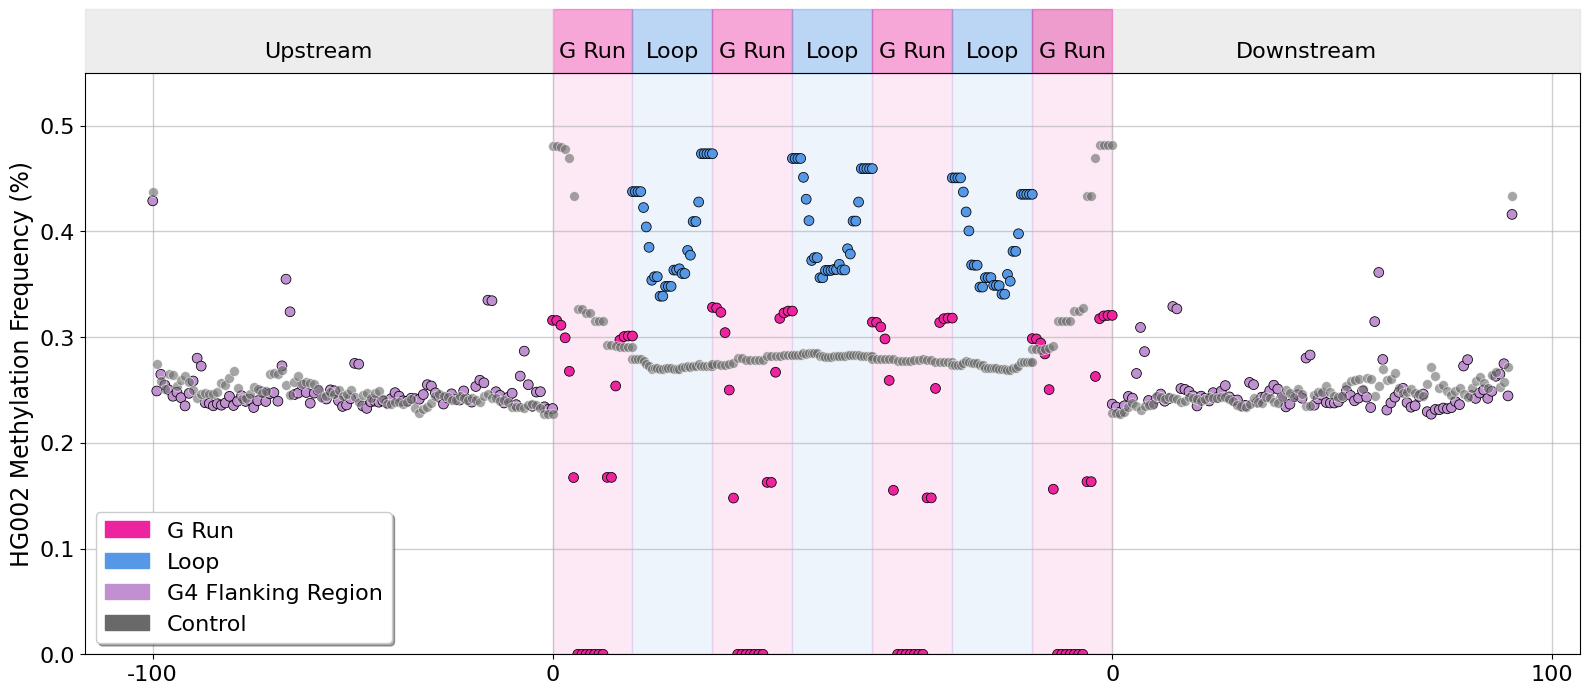

/storage/group/izg5139/default/nicole/g4_t2t_identification/pos_mutations_g4


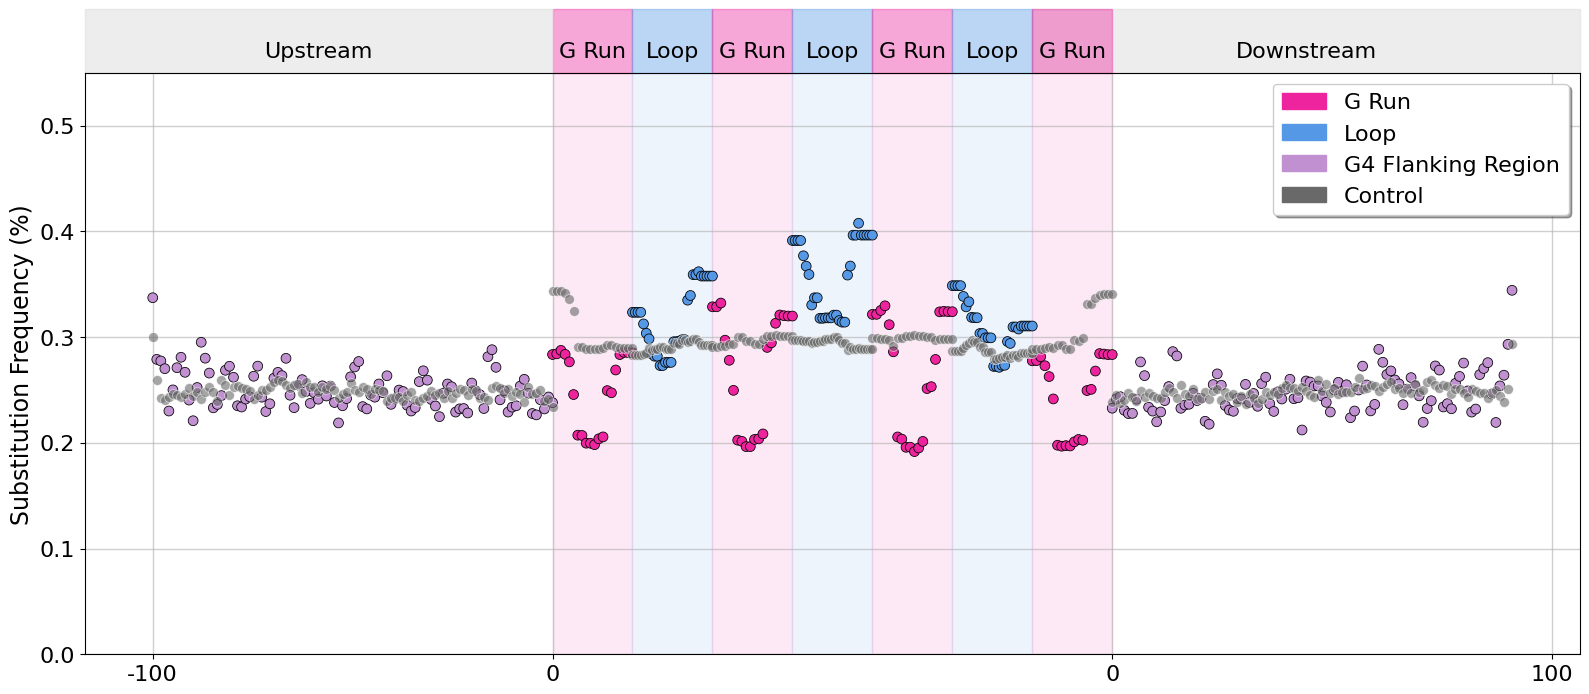

/storage/group/izg5139/default/nicole/g4_t2t_identification/pos_mutations_g4


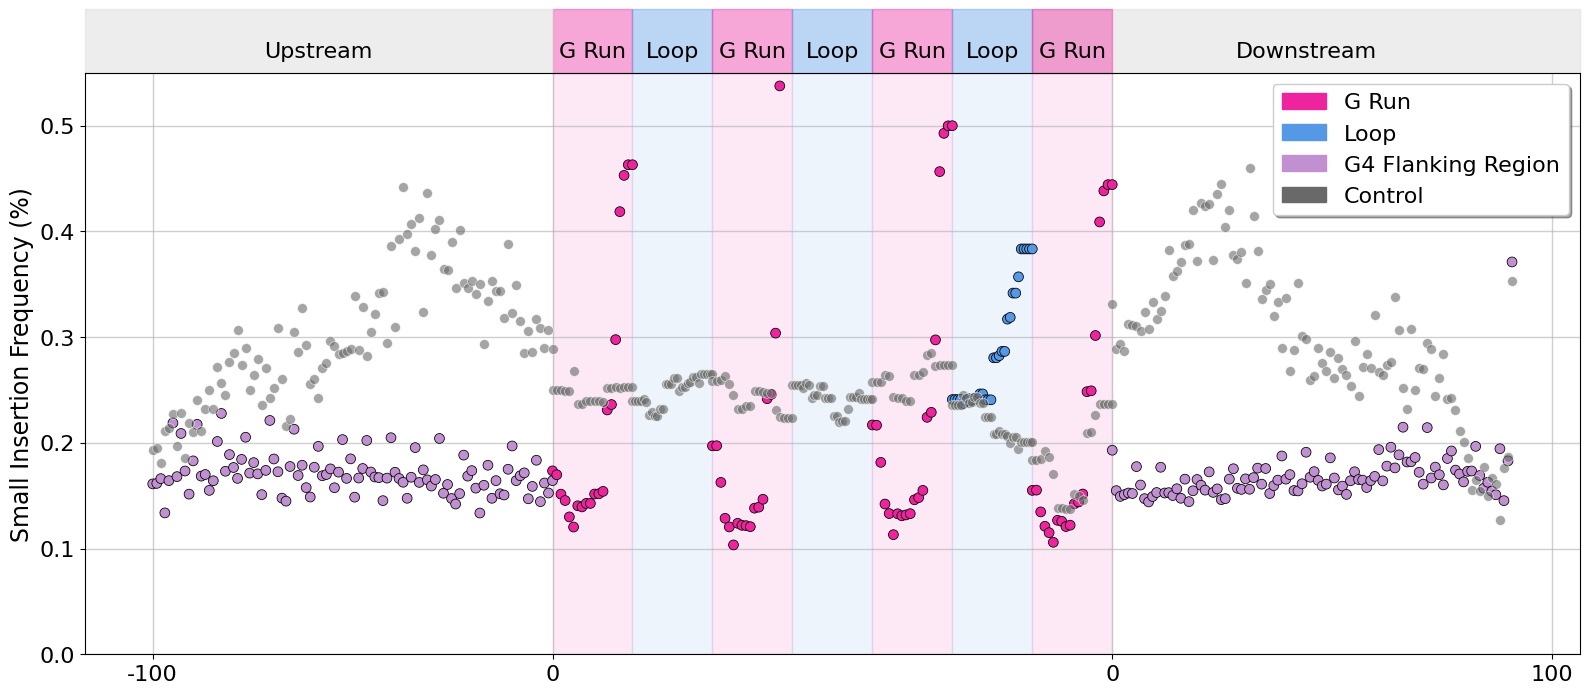

/storage/group/izg5139/default/nicole/g4_t2t_identification/pos_mutations_g4


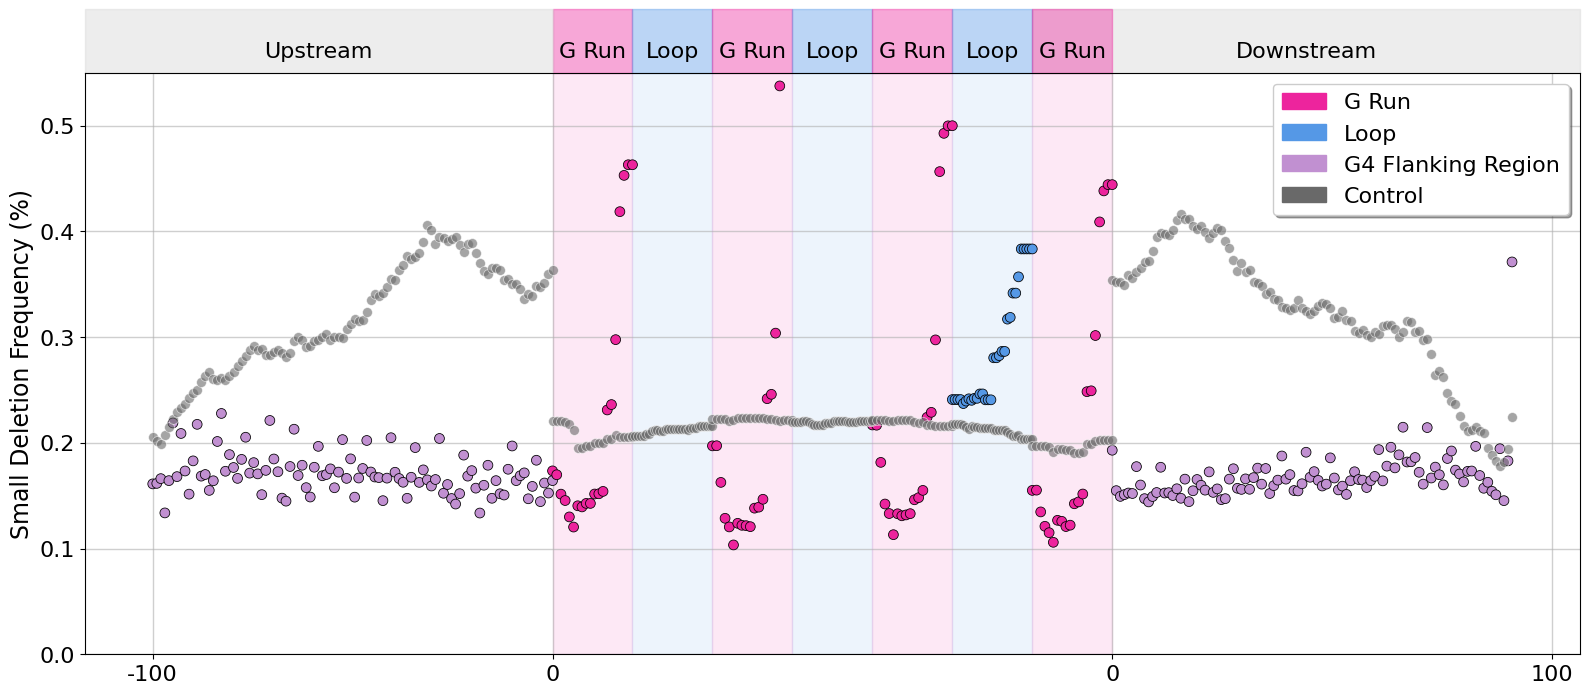

/storage/group/izg5139/default/nicole/g4_t2t_identification/pos_mutations_g4


In [273]:


plot(regex_bin_counts_HG002_CpG_loci_merged, name="HG002_CpG", label="HG002 Methylation")
plot(regex_bin_counts_subs_loci_merged, name="subs", label="Substitution")
plot(regex_bin_counts_smallins_loci_merged, name="smallins", label="Small Insertion")
plot(regex_bin_counts_smalldel_loci_merged, name="smalldel", label="Small Deletion")

## Regex G4 Counts

In [376]:
from Bio.Seq import Seq

def process_g4(regex_expanded_with_subs, bin_size_grun: int = 30, bin_size_loop: int = 20):
    utils = []
    
    bin_size = {0: bin_size_grun,
                1: bin_size_loop}
    bin_counts = [{i+1: 0 for i in range(bin_size[j%2])} for j in range(7)]
    
    thresh = 100
    g4_downstream = [0 for _ in range(thresh)]
    g4_upstream = [0 for _ in range(thresh)]
    
    mutation_loci = []
    regex_expanded_with_subs = filter_y(regex_expanded_with_subs)
    
    for row in tqdm(regex_expanded_with_subs.iter_rows(named=True), 
                    total=regex_expanded_with_subs.shape[0]):
        seqID = row['seqID']
        start = row['start']
        end = row['end']
        end_init = end
        start_init = start
        g4 = row['sequence'].lower()
        strand = "+" if g4[0] == "g" else "-"
        motif = g4[0]
        
        if strand == '-':
            canonical = str(Seq(g4).reverse_complement())
            
        start_mut = row['start_mut']
        end_mut = row['end_mut']
    
        # calculate biophysical properties
        length = len(g4)
        gc_content = g4.count("g") + g4.count("c")
        gruns = re.findall("%s{3,}" % g4[0], g4)
        # grun_lengths = list(map(len, gruns))
        grun_length = sum(map(len, gruns))
        loop_length = grun_length * 1e2 / length
        total_gruns = len(gruns)
    
        if total_gruns != 4:
            continue
    
        if end_mut <= start: 
            g4_downstream[thresh-(start-end_mut)-1] += 1
        elif start_mut >= end:
            g4_upstream[start_mut-end] += 1
        else:
            assert start_mut >= start
            assert end_mut <= end
            # find peak position
            start_mut = max(start, start_mut)
            end_mut = min(end, end_mut)
    
            end -= start
            start_mut -= start
            end_mut -= start
        
            if "variant" in row:
                var = row['variant'].lower()
                ref = row['reference'].lower()
                try:
                    assert g4[start_mut] == ref
                except AssertionError:
                    print(row)
                    continue
            
            mutated_sequence = g4[:start_mut] + var + g4[start_mut+1:]
            mutated_trinucleotide = g4[max(0, start_mut-1): min(start_mut+2, length)].upper()
            transition_tri = mutated_trinucleotide + ">" + g4[max(0, start_mut-1)].upper() + var + g4[min(start_mut+2, length-1)].upper() 
            
            rev = str(Seq(mutated_trinucleotide).reverse_complement())
            if rev < mutated_trinucleotide:
                mutated_trinucleotide_canonical = rev
            else:
                mutated_trinucleotide_canonical = mutated_trinucleotide
            
            invariant = int(is_g4(mutated_sequence))
            validated_g4 = int(is_g4(g4))
    
            mut_pos = start_mut
            # mut_loci, segment_size = detect_loci(g4, mut_pos)  
            small_bin, large_bin, stem_loci, _ = detect_loci(g4, mut_pos, bin_size)        
         
            if total_gruns == 4:
                for cur_bin in range(small_bin, large_bin):
                    bin_counts[stem_loci-1][cur_bin+1] += 1
        
            utils.append(
                    {
                     "seqID": seqID,
                     "start": start_init,
                     "end": end_init,
                     "mutated_trinucleotide": mutated_trinucleotide,
                        "canonical_trinucleotide": mutated_trinucleotide_canonical,
                     "stem_loci": stem_loci,
                     "transition_tri": transition_tri,
                        "transition": ref + ">" + var,
                     # "mut_loci": mut_loci,
                     "sequence": g4,
                     "canonical": canonical,
                     "mutated": mutated_sequence,
                     "invariant": invariant,
                     "is_g4": validated_g4,
                     "length": length,
                     "gc_content": gc_content,
                     "total_gruns": total_gruns,
                     "grun_length": grun_length,  
                     "loop_length": loop_length
                    }
            )
        
    utils = pd.DataFrame(utils)
    return utils, bin_counts, g4_downstream, g4_upstream


utils_smallins, regex_bin_counts_smallins, g4_downstream_smallins, g4_upstream_smallins = process_g4(regex_expanded_with_smallins)
utils_subs, regex_bin_counts_subs, g4_downstream_subs, g4_upstream_subs = process_g4(regex_expanded_with_subs)

100%|██████████| 1263518/1263518 [00:07<00:00, 158794.25it/s]


#### Methylation HG002 for regex-based

In [522]:
bin_size_grun = 30
bin_size_loop = 20

In [545]:
control_bin_counts_HG002_CpG, control_downstream_HG002_CpG, control_upstream_HG002_CpG = process_controls(control_expanded_with_HG002_CpG, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)

100%|██████████| 3073982/3073982 [00:15<00:00, 197023.72it/s]


In [546]:
regex_bin_counts_HG002_CpG, regex_downstream_HG002_CpG, regex_upstream_HG002_CpG = process_controls(regex_expanded_with_HG002_CpG, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)

100%|██████████| 2534697/2534697 [00:11<00:00, 218595.87it/s]


In [523]:
control_bin_counts_HG002_hyper, control_downstream_HG002_hyper, control_upstream_HG002_hyper = process_controls(control_expanded_with_HG002_hyper, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)
control_bin_counts_HG002_meth, control_downstream_HG002_meth, control_upstream_HG002_meth = process_controls(control_expanded_with_HG002_meth, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)
control_bin_counts_HG002_hypo, control_downstream_HG002_hypo, control_upstream_HG002_hypo = process_controls(control_expanded_with_HG002_hypo, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)

regex_bin_counts_HG002_hyper, regex_downstream_HG002_hyper, regex_upstream_HG002_hyper = process_controls(regex_expanded_with_HG002_hyper, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)
regex_bin_counts_HG002_meth, regex_downstream_HG002_meth, regex_upstream_HG002_meth = process_controls(regex_expanded_with_HG002_meth, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)
regex_bin_counts_HG002_hypo, regex_downstream_HG002_hypo, regex_upstream_HG002_hypo = process_controls(regex_expanded_with_HG002_hypo, bin_size_grun=bin_size_grun, bin_size_loop=bin_size_loop)

100%|██████████| 1115307/1115307 [00:05<00:00, 220780.14it/s]


In [526]:
regex_bin_counts_HG002_hyper = pd.DataFrame(regex_bin_counts_HG002_hyper)
control_bin_counts_HG002_hyper =  pd.DataFrame(control_bin_counts_HG002_hyper)

regex_bin_counts_HG002_meth = pd.DataFrame(regex_bin_counts_HG002_meth)
control_bin_counts_HG002_meth =  pd.DataFrame(control_bin_counts_HG002_meth)

regex_bin_counts_HG002_hypo = pd.DataFrame(regex_bin_counts_HG002_hypo)
control_bin_counts_HG002_hypo =  pd.DataFrame(control_bin_counts_HG002_hypo)

In [528]:
thresh = 100

bin_size = {0: bin_size_grun,
                1: bin_size_loop}

regex_bin_counts_HG002_hyper = pd.DataFrame(regex_bin_counts_HG002_hyper)
control_bin_counts_HG002_hyper =  pd.DataFrame(control_bin_counts_HG002_hyper)

regex_bin_counts_HG002_meth = pd.DataFrame(regex_bin_counts_HG002_meth)
control_bin_counts_HG002_meth =  pd.DataFrame(control_bin_counts_HG002_meth)

regex_bin_counts_HG002_hypo = pd.DataFrame(regex_bin_counts_HG002_hypo)
control_bin_counts_HG002_hypo =  pd.DataFrame(control_bin_counts_HG002_hypo)

# hyper
g4_HG002_hyper_loci, coords_system  = transform(regex_bin_counts_HG002_hyper.copy(), 
                                    regex_downstream_HG002_hyper.copy(), 
                                    regex_upstream_HG002_hyper.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_HG002_hyper_loci, coords_system  = transform(control_bin_counts_HG002_hyper, 
                                    control_downstream_HG002_hyper.copy(), 
                                    control_downstream_HG002_hyper.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )

# meth
g4_HG002_meth_loci, coords_system  = transform(regex_bin_counts_HG002_meth.copy(), 
                                    regex_downstream_HG002_meth.copy(), 
                                    regex_upstream_HG002_meth.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_HG002_meth_loci, coords_system  = transform(control_bin_counts_HG002_meth, 
                                    control_downstream_HG002_meth.copy(), 
                                    control_downstream_HG002_meth.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )

# hypo
g4_HG002_hypo_loci, coords_system  = transform(regex_bin_counts_HG002_hypo.copy(), 
                                    regex_downstream_HG002_hypo.copy(), 
                                    regex_upstream_HG002_hypo.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_HG002_hypo_loci, coords_system  = transform(control_bin_counts_HG002_hypo, 
                                    control_downstream_HG002_hypo.copy(), 
                                    control_downstream_HG002_hypo.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )

# merge g4 with controls

g4_HG002_hyper_loci_merged = g4_HG002_hyper_loci.merge(control_HG002_hyper_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))
g4_HG002_meth_loci_merged = g4_HG002_meth_loci.merge(control_HG002_meth_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))
g4_HG002_hypo_loci_merged = g4_HG002_hypo_loci.merge(control_HG002_hypo_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))
g4_HG002_hypo_loci_merged

3.5
100
280
380
3.5
100
280
380
3.5
100
280
380
3.5
100
280
380
3.5
100
280
380
3.5
100
280
380


,loci,counts,label,perc,counts_control,perc_control
0,-2.100000,3493.0,flanking,0.231598,3523.0,0.226829
1,-2.079798,3510.0,flanking,0.232726,3425.0,0.220519
2,-2.059596,3469.0,flanking,0.230007,3507.0,0.225799
3,-2.039394,3460.0,flanking,0.229410,3373.0,0.217171
4,-2.019192,3543.0,flanking,0.234914,3437.0,0.221292
...,...,...,...,...,...,...
375,5.519192,3530.0,flanking,0.234052,4273.0,0.275118
376,5.539394,3467.0,flanking,0.229875,4168.0,0.268357
377,5.559596,3517.0,flanking,0.233190,4008.0,0.258056
378,5.579798,3435.0,flanking,0.227753,4434.0,0.285484


In [547]:
regex_bin_counts_HG002_CpG = pd.DataFrame(regex_bin_counts_HG002_CpG)
control_bin_counts_HG002_CpG =  pd.DataFrame(control_bin_counts_HG002_CpG)

In [548]:
thresh = 100

bin_size = {0: bin_size_grun,
                1: bin_size_loop}
g4_HG002_CpG_loci, coords_system  = transform(regex_bin_counts_HG002_CpG.copy(), 
                                    regex_downstream_HG002_CpG.copy(), 
                                    regex_upstream_HG002_CpG.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
control_HG002_CpG_loci, coords_system  = transform(control_bin_counts_HG002_CpG, 
                                    control_downstream_HG002_CpG.copy(), 
                                    control_downstream_HG002_CpG.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )

3.5
100
280
380
3.5
100
280
380


In [549]:
g4_HG002_CpG_loci_merged = g4_HG002_CpG_loci.merge(control_HG002_CpG_loci, on=["loci", "label"], how="left", suffixes=("", "_control"))
g4_HG002_CpG_loci_merged.head()

,loci,counts,label,perc,counts_control,perc_control
0,-2.100000,8038.0,flanking,0.236625,10328.0,0.205062
1,-2.079798,7936.0,flanking,0.233622,10634.0,0.211138
2,-2.059596,7838.0,flanking,0.230737,10391.0,0.206313
3,-2.039394,7591.0,flanking,0.223466,10477.0,0.208021
4,-2.019192,8214.0,flanking,0.241806,10623.0,0.210920


In [113]:
def plot(g4_HG002_CpG_loci_merged):
    import matplotlib.patches as mpatches
    colors = ["#ed249d", "#5598e6"]
    labels = ["G Run", "Loop"]
    control_color = "dimgray"
    flanking_reg_color = "#c190d1"
    label_palette = {"flanking": flanking_reg_color,
                     "G Run": colors[0],
                     "Loop" : colors[1]
                    }
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
    sns.scatterplot(data=g4_HG002_CpG_loci_merged, 
                    x="loci", 
                    y="perc",
                    s=50,
                    
                    hue="label",
                    edgecolor="black",          
                    # linewidth=2,                 
                    palette=label_palette,
                    # marker="o" ,
                   ax=ax)
    sns.scatterplot(data=g4_HG002_CpG_loci_merged, 
                    x="loci", 
                    y="perc_control",
                    s=50,
                    alpha=0.6,
                    # linewidth=2,                 
                    color=control_color,
                    marker="o" ,
                    zorder=1,
                   ax=ax)
    
    for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
        ax.axvspan(x, y, color=colors[i%2], alpha=0.1, zorder=0)
    ax.axvspan(y, y+0.5, color=colors[0], alpha=0.1, zorder=0)
    
    
    ymax = ax.get_ylim()[1]
    # ax.set_ylim(ymin=0.0)
    ymax = ax.get_ylim()[1]
    ytext = ymax + 0.02 * ymax 
    rect_height = 0.09 * ymax
    
    for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
        color = colors[i%2]
        ax.add_patch(plt.Rectangle((x, ymax), 
                                   y - x, 
                                   rect_height, 
                                   color=color, 
                                   alpha=0.4, 
                                   transform=ax.transData, clip_on=False))
        ax.text((x + y) / 2, ytext, 
                labels[i%2], 
                ha="center", 
                va="bottom", 
                fontsize=16,
                
                color="black")
    ax.add_patch(plt.Rectangle((y, ymax), 
                               0.5, 
                               rect_height, 
                               color=colors[0], 
                               alpha=0.4, 
                               transform=ax.transData, clip_on=False))
    ax.text((2*y + 0.5) / 2, ytext, 
            labels[0], 
            ha="center", 
            va="bottom", 
                fontsize=16, 
                color="black")
        
    ax.add_patch(plt.Rectangle((ax.get_xlim()[0], ymax),
                               coords_system[0] - ax.get_xlim()[0],
                               rect_height,
                               color="lightgray",
                               alpha=0.4,
                               transform=ax.transData, clip_on=False))
    ax.text(ax.get_xlim()[0] + (coords_system[0] - ax.get_xlim()[0]) / 2,
            ytext,
            "Upstream",
            ha="center", 
            va="bottom", 
            fontsize=16, 
            color="black")
    
    ax.add_patch(plt.Rectangle((coords_system[-1], ymax),
                               ax.get_xlim()[1] - coords_system[-1],
                               rect_height,
                               color="lightgray",
                               alpha=0.4,
                               zorder=0,
                               transform=ax.transData, 
                               clip_on=False))
    ax.text(coords_system[-1] + (ax.get_xlim()[1] - coords_system[-1]) / 2,
            ytext,
            "Downstream",
            ha="center", 
            va="bottom", 
            zorder=3,
            fontsize=16, 
            color="black")
    
    ax.grid(lw=1.0, zorder=0)
    ax.set_axisbelow(True)
    ax.set_ylabel("HG002 Methylation Frequency (%)")
    ax.set_xlabel("G4")
    ax.xaxis.label.set_size(18)
    ax.yaxis.label.set_size(17)
    # xticks = ax.get_xticks()
    # labels = list(range(-thresh, 0)) + [int(x) for x in xticks[thresh:-thresh]] + list(range(1, thresh+1))
    # ax.set_xticklabels(labels)
    
    ax.tick_params(axis="both", labelsize=16)
    ax.legend(handles=[mpatches.Patch(color=colors[0], label="G Run"),
                       mpatches.Patch(color=colors[1], label="Loop"),
                       mpatches.Patch(color=flanking_reg_color, label="G4 Flanking Region"),
                       mpatches.Patch(color=control_color, label="Control")
                      ],
              prop={"size": 16},
              # bbox_to_anchor=(1.3, 0.8),
              fancybox=True,
              loc=0,
              shadow=True,
              title="",
             )
    target.mkdir(exist_ok=True)
    # fig.savefig(f"{target}/HG002_methylation_CpG_g4_vs_control_pos.pdf", bbox_inches="tight", dpi=300)
    plt.tight_layout()
    plt.show()

## Data Visualization

In [370]:
mut_grp = utils.query("total_gruns == 4").groupby(["transition_tri", "stem_loci"], as_index=False)\
                        .agg(total_counts=("is_g4", lambda ds: 1e2 * ds.count() / utils.shape[0])).sort_values(by=['total_counts'], ascending=False).head(40)

/tmp/ipykernel_3235106/3816957508.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:gray'` for the same effect.

  sns.barplot(data=mut_grp, x="mutated_trinucleotide", y="total_counts", hue="stem_loci", color="gray", edgecolor="black", ax=ax)


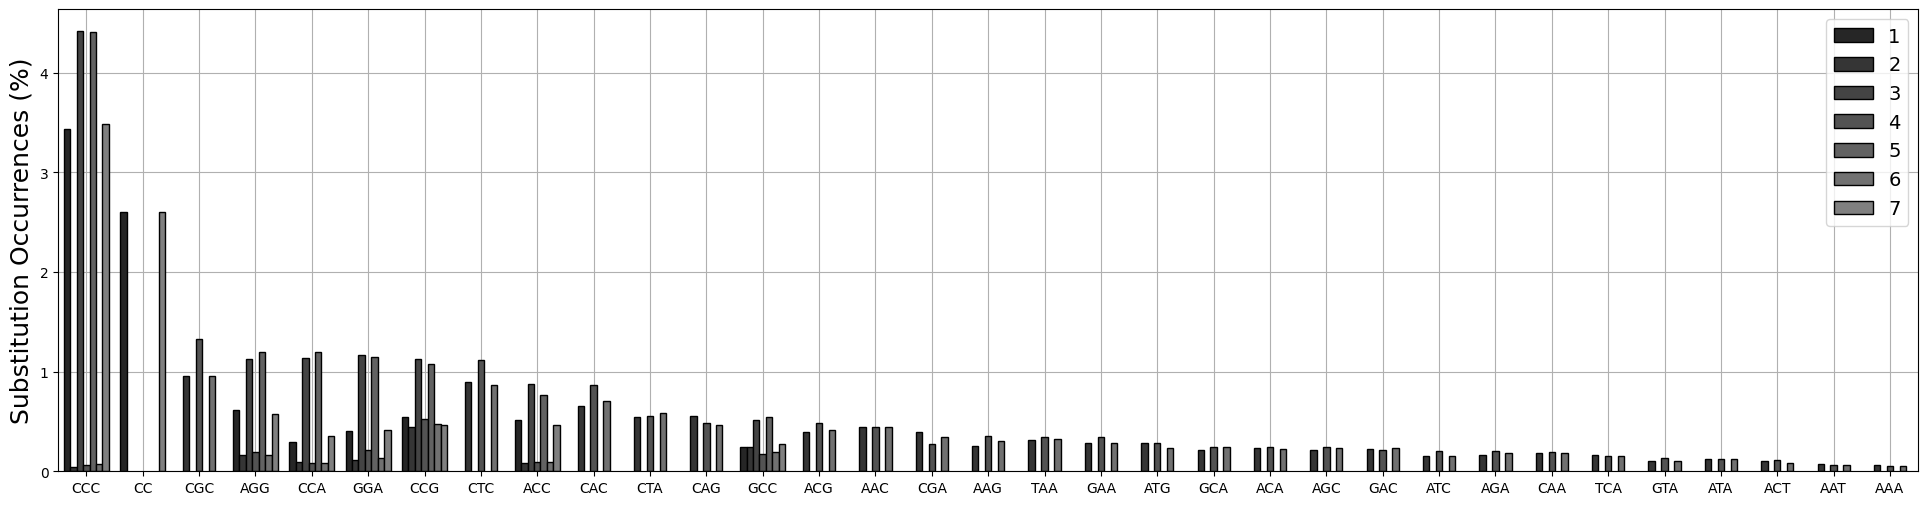

In [62]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(24, 6))

sns.barplot(data=mut_grp, x="mutated_trinucleotide", y="total_counts", hue="stem_loci", color="gray", edgecolor="black", ax=ax)
ax.grid()
ax.set_xlabel("")
ax.set_ylabel("Substitution Occurrences (%)")
ax.yaxis.label.set_size(18)
ax.set_axisbelow(True)
ax.legend(title="", prop={"size": 14})

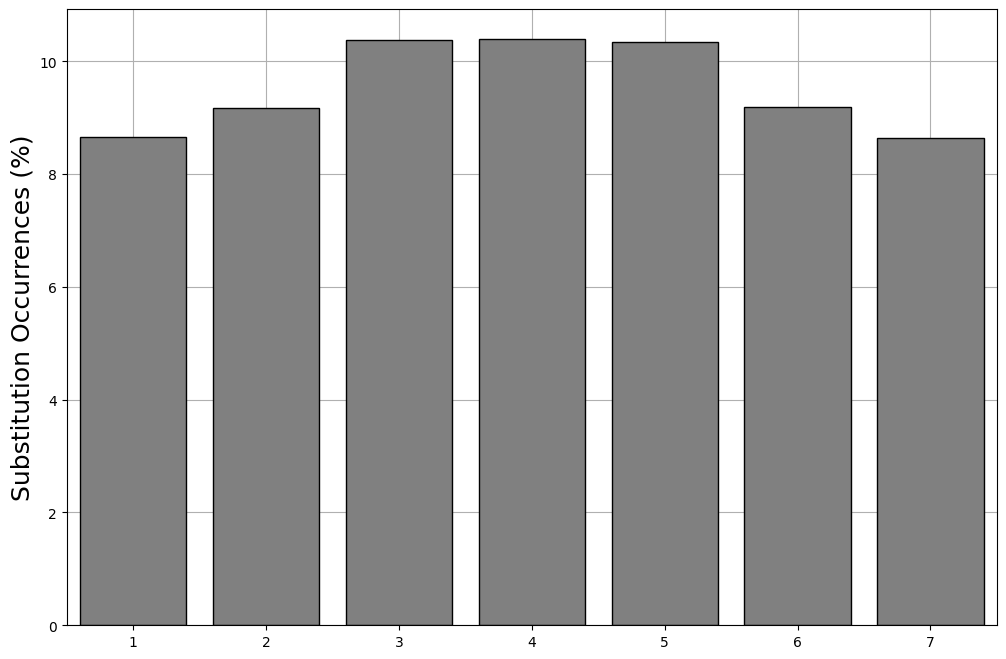

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

mut_grp = utils.query("total_gruns == 4").groupby("stem_loci", as_index=False).agg(total_counts=("is_g4", lambda ds: 1e2 * ds.count() / utils.shape[0]))

sns.barplot(data=mut_grp, x="stem_loci", y="total_counts", color="gray", edgecolor="black", ax=ax)
ax.grid()
ax.set_xlabel("")
ax.set_ylabel("Substitution Occurrences (%)")
ax.yaxis.label.set_size(18)
ax.set_axisbelow(True)

In [293]:
bin_counts_df = pd.DataFrame(bin_counts)


In [316]:
bin_counts_df.fillna(0.0).sum().sum()

816771.0

In [317]:
sum(g4_downstream) + sum(g4_upstream)

802591

In [383]:
control_bin_counts_smallins = pd.DataFrame(control_bin_counts_smallins)
regex_bin_counts_smallins =  pd.DataFrame(regex_bin_counts_smallins)

control_bin_counts_subs = pd.DataFrame(control_bin_counts_subs)
regex_bin_counts_subs =  pd.DataFrame(regex_bin_counts_subs)


regex_bin_counts_subs

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
0,4567,4569,4577,4595,4631,4569,4454,4012,3957,3955,...,4017.0,3981.0,4344.0,4331.0,4501.0,4615.0,4599.0,4596.0,4594.0,4594.0
1,5210,5210,5033,4891,4806,4541,4399,4399,4447,4447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5294,5295,5294,5310,5353,4785,4477,4084,4021,4022,...,4675.0,4747.0,5051.0,5043.0,5207.0,5172.0,5158.0,5151.0,5153.0,5153.0
3,6304,6304,6071,5913,5786,5431,5119,5119,5125,5125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5179,5180,5179,5193,5242,5309,5021,4672,4608,4605,...,4048.0,4076.0,4491.0,4492.0,4699.0,5233.0,5225.0,5221.0,5219.0,5219.0
5,5616,5616,5452,5293,5370,5127,4887,4887,4821,4821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4471,4470,4474,4502,4535,4396,4232,3939,3890,3891,...,4018.0,4037.0,4319.0,4315.0,4555.0,4574.0,4574.0,4562.0,4566.0,4566.0


In [379]:
len(control_downstream), sum(control_downstream), len(control_upstream)

(100, 444931, 100)

In [375]:
len(g4_downstream), sum(g4_downstream), len(g4_upstream), sum(g4_upstream)

(100, 399740, 100, 402851)

In [396]:
import numpy as np

def transform(bin_counts_df, downstream, upstream, bin_size, thresh, total_peaks = 7, rescale=2):
    total_counts = 0
    upper = total_peaks / rescale
    print(upper)
    offset = 0.1
    segment_length = 2.0
    coords = [i + j for k, i in enumerate(np.arange(0.0, upper, 0.5)) for j in np.arange(0.0, 0.5, 1/bin_size[k%2] / rescale)]
    coords_system = [i for i in np.arange(0.0, upper, 0.5)]
    
    upstream_xs= [i for i in np.linspace(- offset - segment_length, 0.0 - offset, thresh)]
    downstream_xs =  [i for i in np.linspace(upper+offset, upper+ offset+segment_length, thresh)]
    xs = np.array(upstream_xs + coords + downstream_xs)

    typ = ["G Run", "Loop"]
    labels = ["flanking"] * len(upstream_xs)
    labels += [typ[k%2] for k, i in enumerate(np.arange(0.0, upper, 0.5)) for j in np.arange(0.0, 0.5, 1/bin_size[k%2] / rescale)]
    labels += ["flanking"] * len(downstream_xs)
    labels = np.array(labels)
    
    total_counts += sum(downstream) + sum(upstream)
    ys = downstream.copy()
    print(len(ys))
    
    for _, row in bin_counts_df.iterrows():
        for x in row:
            if np.isnan(x):
                continue    
            ys.append(x)
            total_counts += x
            
    print(len(ys))
    ys += upstream
    print(len(ys))
    ys = np.array(ys)
    assert ys.shape == xs.shape == labels.shape, f"{ys.shape},{xs.shape}"
    
    mut_loci = pd.DataFrame({"loci": xs, "counts": ys, "label": labels})
    mut_loci.loc[:, "perc"] = 1e2 * mut_loci["counts"] / total_counts
    return mut_loci, coords_system

thresh = 100
mut_loci_subs, coords_system  = transform(regex_bin_counts_subs.copy(), 
                                    g4_downstream_subs.copy(), 
                                    g4_upstream_subs.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )
mut_loci_smallins, coords_system  = transform(regex_bin_counts_smallins, 
                                    g4_downstream_smallins.copy(), 
                                    g4_upstream_smallins.copy(), 
                                    bin_size, 
                                    thresh, 
                                    total_peaks=7,
                                    )


mut_loci_control_subs, _ = transform(control_bin_counts_subs.copy(), 
                                            control_downstream_subs.copy(), 
                                            control_upstream_subs.copy(), 
                                            bin_size, 
                                            thresh, 
                                            total_peaks=7)
mut_loci_control_smallins, _ = transform(control_bin_counts_smallins.copy(), 
                                            control_downstream_smallins.copy(), 
                                            control_upstream_smallins.copy(), 
                                            bin_size, 
                                            thresh, 
                                            total_peaks=7)
mut_loci_smallins

3.5
100
280
380
3.5
100
280
380
3.5
100
280
380
3.5
100
280
380


,loci,counts,label,perc
0,-2.100000,1631.0,flanking,0.207672
1,-2.079798,1308.0,flanking,0.166545
2,-2.059596,1262.0,flanking,0.160688
3,-2.039394,1276.0,flanking,0.162471
4,-2.019192,1289.0,flanking,0.164126
...,...,...,...,...
375,5.519192,1551.0,flanking,0.197486
376,5.539394,1220.0,flanking,0.155340
377,5.559596,1369.0,flanking,0.174312
378,5.579798,1289.0,flanking,0.164126


In [397]:
mut_loci_subs = mut_loci_subs.merge(mut_loci_control_subs, on=["loci", "label"], how="left", suffixes=("", "_control"))
mut_loci_smallins = mut_loci_smallins.merge(mut_loci_control_smallins, on=["loci", "label"], how="left", suffixes=("", "_control"))
mut_loci_smallins

,loci,counts,label,perc,counts_control,perc_control
0,-2.100000,1631.0,flanking,0.207672,648.0,0.323670
1,-2.079798,1308.0,flanking,0.166545,566.0,0.282712
2,-2.059596,1262.0,flanking,0.160688,575.0,0.287207
3,-2.039394,1276.0,flanking,0.162471,562.0,0.280714
4,-2.019192,1289.0,flanking,0.164126,612.0,0.305688
...,...,...,...,...,...,...
375,5.519192,1551.0,flanking,0.197486,620.0,0.309684
376,5.539394,1220.0,flanking,0.155340,605.0,0.302192
377,5.559596,1369.0,flanking,0.174312,568.0,0.283711
378,5.579798,1289.0,flanking,0.164126,601.0,0.300194


In [386]:
# from scipy.stats import binom_test

# binom_test(42, n=2000, p=0.015, alternative="greater")

# mut_loci.loc[:, "significance"] = mut_loci[["perc", "perc_control"]].apply(lambda row:binom_test(42, n=row[", p=row["perc_control"], alternative="greater")(row["perc"], row["perc_control"]).pval, axis=1)
# mut_loci

In [395]:
mut_loci_smallins

,loci,counts,label,perc,counts_control,perc_control,counts_control,perc_control,counts_control,perc_control
0,-2.100000,3749.0,flanking,0.231511,4274.0,0.230956,4274.0,0.230956,648.0,0.323670
1,-2.079798,3890.0,flanking,0.240218,4390.0,0.237225,4390.0,0.237225,566.0,0.282712
2,-2.059596,3924.0,flanking,0.242318,4248.0,0.229552,4248.0,0.229552,575.0,0.287207
3,-2.039394,3717.0,flanking,0.229535,4307.0,0.232740,4307.0,0.232740,562.0,0.280714
4,-2.019192,3667.0,flanking,0.226447,4423.0,0.239008,4423.0,0.239008,612.0,0.305688
...,...,...,...,...,...,...,...,...,...,...
375,5.519192,3647.0,flanking,0.225212,4425.0,0.239116,4425.0,0.239116,620.0,0.309684
376,5.539394,3878.0,flanking,0.239477,4471.0,0.241602,4471.0,0.241602,605.0,0.302192
377,5.559596,3738.0,flanking,0.230832,4297.0,0.232199,4297.0,0.232199,568.0,0.283711
378,5.579798,3920.0,flanking,0.242071,4326.0,0.233766,4326.0,0.233766,601.0,0.300194


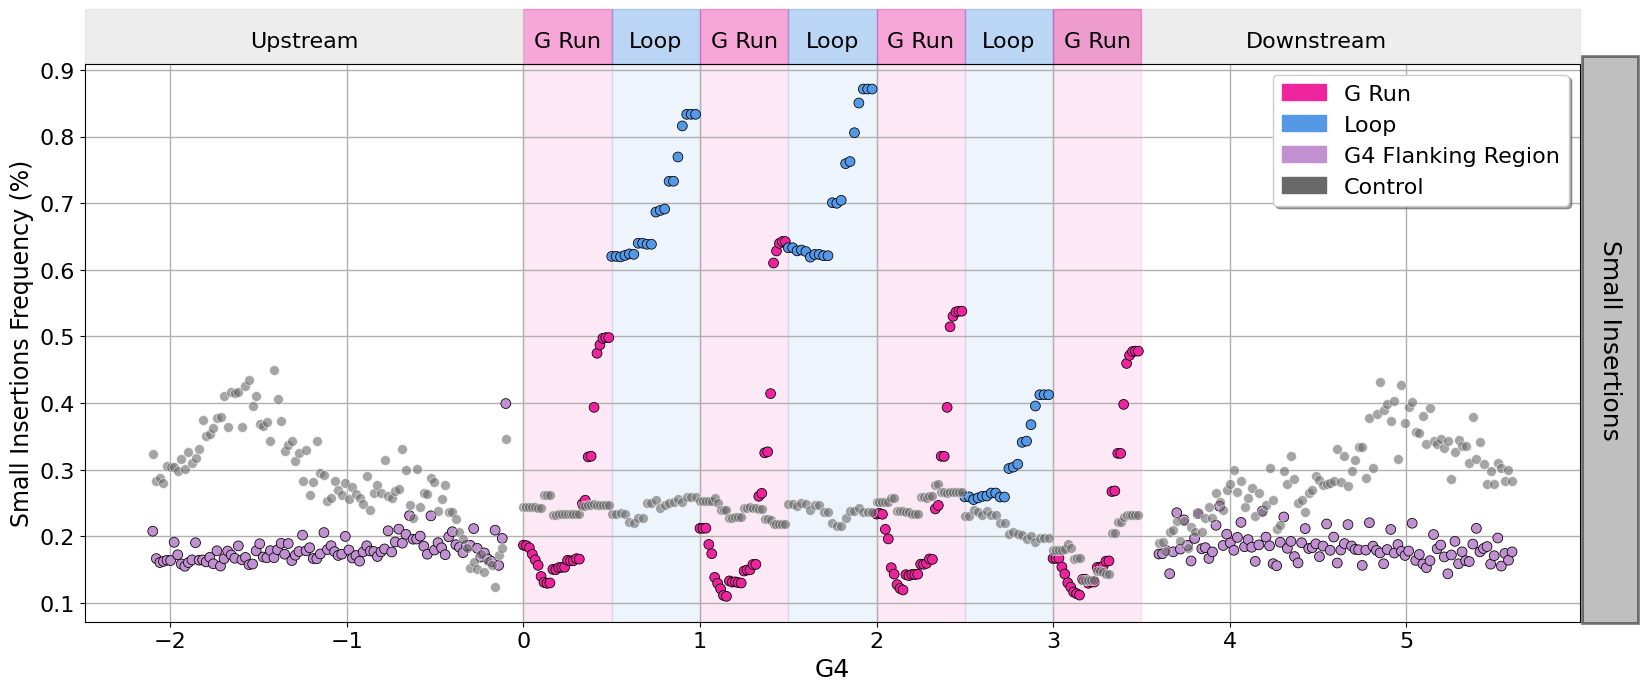

In [468]:
import matplotlib.patches as mpatches


colors = ["#ed249d", "#5598e6"]
labels = ["G Run", "Loop"]
control_color = "dimgray"
flanking_reg_color = "#c190d1"
label_palette = {"flanking": flanking_reg_color,
                 "G Run": colors[0],
                 "Loop" : colors[1]
                }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
sns.scatterplot(data=mut_loci_smallins, 
                x="loci", 
                y="perc",
                s=50,
                
                hue="label",
                edgecolor="black",          
                # linewidth=2,                 
                palette=label_palette,
                # marker="o" ,
               ax=ax)
sns.scatterplot(data=mut_loci_smallins, 
                x="loci", 
                y="perc_control",
                s=50,
                alpha=0.6,
                # linewidth=2,                 
                color=control_color,
                marker="o" ,
                zorder=1,
               ax=ax)

for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
    ax.axvspan(x, y, color=colors[i%2], alpha=0.1, zorder=0)
ax.axvspan(y, y+0.5, color=colors[0], alpha=0.1, zorder=0)


ymax = ax.get_ylim()[1]
# ax.set_ylim(ymin=0.0)
ymax = ax.get_ylim()[1]
ytext = ymax + 0.02 * ymax 
rect_height = 0.09 * ymax

for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
    color = colors[i%2]
    ax.add_patch(plt.Rectangle((x, ymax), 
                               y - x, 
                               rect_height, 
                               color=color, 
                               alpha=0.4, 
                               transform=ax.transData, clip_on=False))
    ax.text((x + y) / 2, ytext, 
            labels[i%2], 
            ha="center", 
            va="bottom", 
            fontsize=16,
            
            color="black")
ax.add_patch(plt.Rectangle((y, ymax), 
                           0.5, 
                           rect_height, 
                           color=colors[0], 
                           alpha=0.4, 
                           transform=ax.transData, clip_on=False))
ax.text((2*y + 0.5) / 2, ytext, 
        labels[0], 
        ha="center", 
        va="bottom", 
        fontsize=16, 
        color="black")
    
ax.add_patch(plt.Rectangle((ax.get_xlim()[0], ymax),
                           coords_system[0] - ax.get_xlim()[0],
                           rect_height,
                           color="lightgray",
                           alpha=0.4,
                           transform=ax.transData, clip_on=False))
ax.text(ax.get_xlim()[0] + (coords_system[0] - ax.get_xlim()[0]) / 2,
        ytext,
        "Upstream",
        ha="center", 
        va="bottom", 
        fontsize=16, 
        color="black")

ax.add_patch(plt.Rectangle((coords_system[-1], ymax),
                           ax.get_xlim()[1] - coords_system[-1],
                           rect_height,
                           color="lightgray",
                           alpha=0.4,
                           zorder=0,
                           transform=ax.transData, 
                           clip_on=False))
ax.text(coords_system[-1] + (ax.get_xlim()[1] - coords_system[-1]) / 2,
        ytext,
        "Downstream",
        ha="center", 
        va="bottom", 
        zorder=3,
        fontsize=16, 
        color="black")

ax.grid(lw=1.0, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Small Insertions Frequency (%)")
ax.set_xlabel("G4")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(17)
# xticks = ax.get_xticks()
# labels = list(range(-thresh, 0)) + [int(x) for x in xticks[thresh:-thresh]] + list(range(1, thresh+1))
# ax.set_xticklabels(labels)

ax.tick_params(axis="both", labelsize=16)
ax.legend(handles=[mpatches.Patch(color=colors[0], label="G Run"),
                   mpatches.Patch(color=colors[1], label="Loop"),
                   mpatches.Patch(color=flanking_reg_color, label="G4 Flanking Region"),
                   mpatches.Patch(color=control_color, label="Control")
                  ],
          prop={"size": 16},
          # bbox_to_anchor=(1.3, 0.8),
          fancybox=True,
          loc=0,
          shadow=True,
          title="",
         )

fig.canvas.draw()
bbox = ax.get_position()
rect_width = 0.035
rect_left = bbox.x1 + 0.092
rect_height = ax.get_ylim()[1] - 0.1 # bbox.y1 - bbox.y0 + 0.1
rect_bottom = bbox.y0 - 0.005

fig.patches.append(plt.Rectangle((rect_left, rect_bottom), 
                             rect_width, 
                             rect_height,
                             edgecolor="black",
                             linewidth=2.0,
                             transform=fig.transFigure, facecolor='gray', alpha=0.5))

# Add title text
fig.text(rect_left + rect_width / 2, 
         rect_bottom + rect_height / 2, 
         s="Small Insertions",
         ha='center', 
         va='center', 
         color='black',
         rotation=270,
         fontsize=18
        )

target.mkdir(exist_ok=True)
fig.savefig(f"{target}/smallins_g4_vs_control_pos.pdf", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()

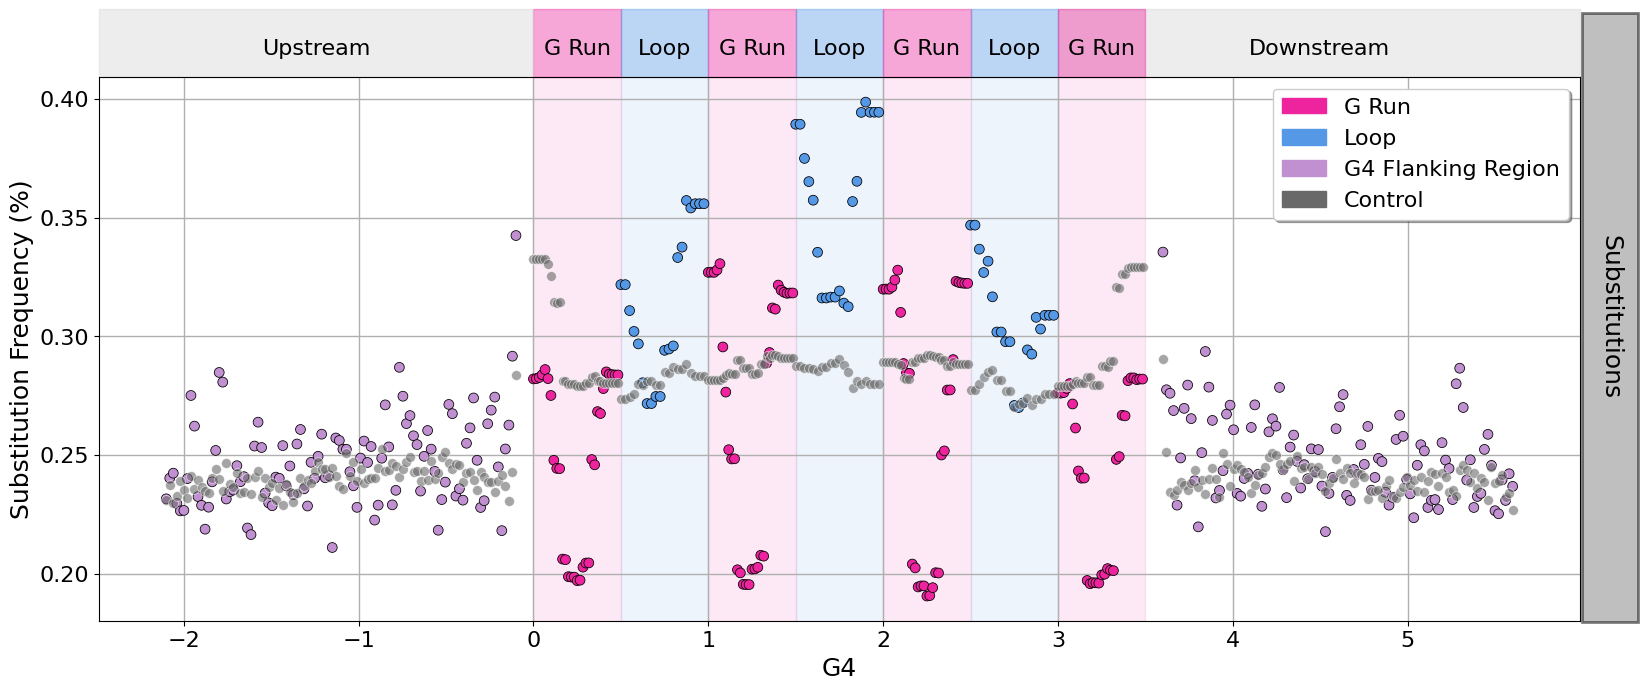

In [470]:
import matplotlib.patches as mpatches


colors = ["#ed249d", "#5598e6"]
labels = ["G Run", "Loop"]
control_color = "dimgray"
flanking_reg_color = "#c190d1"
label_palette = {"flanking": flanking_reg_color,
                 "G Run": colors[0],
                 "Loop" : colors[1]
                }
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 7))
sns.scatterplot(data=mut_loci_subs, 
                x="loci", 
                y="perc",
                s=50,
                
                hue="label",
                edgecolor="black",          
                # linewidth=2,                 
                palette=label_palette,
                # marker="o" ,
               ax=ax)
sns.scatterplot(data=mut_loci_subs, 
                x="loci", 
                y="perc_control",
                s=50,
                alpha=0.6,
                # linewidth=2,                 
                color=control_color,
                marker="o" ,
                zorder=1,
               ax=ax)

# ax.set_ylim(ymin=0.0, ymax=0.5)
for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
    ax.axvspan(x, y, color=colors[i%2], alpha=0.1, zorder=0)
ax.axvspan(y, y+0.5, color=colors[0], alpha=0.1, zorder=0)


ymax = ax.get_ylim()[1]
ytext = ymax + 0.02 * ymax 
rect_height = 0.07 * ymax

for i, (x, y) in enumerate(zip(coords_system, coords_system[1:])):
    color = colors[i%2]
    ax.add_patch(plt.Rectangle((x, ymax), 
                               y - x, 
                               rect_height, 
                               color=color, 
                               alpha=0.4, 
                               transform=ax.transData, clip_on=False))
    ax.text((x + y) / 2, ytext, 
            labels[i%2], 
            ha="center", 
            va="bottom", 
            fontsize=16,
            
            color="black")
ax.add_patch(plt.Rectangle((y, ymax), 
                           0.5, 
                           rect_height, 
                           color=colors[0], 
                           alpha=0.4, 
                           transform=ax.transData, clip_on=False))
ax.text((2*y + 0.5) / 2, ytext, 
        labels[0], 
        ha="center", 
        va="bottom", 
        fontsize=16, 
        color="black")
    
ax.add_patch(plt.Rectangle((ax.get_xlim()[0], ymax),
                           coords_system[0] - ax.get_xlim()[0],
                           rect_height,
                           color="lightgray",
                           alpha=0.4,
                           transform=ax.transData, clip_on=False))
ax.text(ax.get_xlim()[0] + (coords_system[0] - ax.get_xlim()[0]) / 2,
        ytext,
        "Upstream",
        ha="center", 
        va="bottom", 
        fontsize=16, 
        color="black")

ax.add_patch(plt.Rectangle((coords_system[-1], ymax),
                           ax.get_xlim()[1] - coords_system[-1],
                           rect_height,
                           color="lightgray",
                           alpha=0.4,
                           zorder=0,
                           transform=ax.transData, 
                           clip_on=False))
ax.text(coords_system[-1] + (ax.get_xlim()[1] - coords_system[-1]) / 2,
        ytext,
        "Downstream",
        ha="center", 
        va="bottom", 
        zorder=3,
        fontsize=16, 
        color="black")

ax.grid(lw=1.0, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Substitution Frequency (%)")
ax.set_xlabel("G4")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
# xticks = ax.get_xticks()
# labels = list(range(-thresh, 0)) + [int(x) for x in xticks[thresh:-thresh]] + list(range(1, thresh+1))
# ax.set_xticklabels(labels)

ax.tick_params(axis="both", labelsize=16)
ax.legend(handles=[mpatches.Patch(color=colors[0], label="G Run"),
                   mpatches.Patch(color=colors[1], label="Loop"),
                   mpatches.Patch(color=flanking_reg_color, label="G4 Flanking Region"),
                   mpatches.Patch(color=control_color, label="Control")
                  ],
          prop={"size": 16},
          # bbox_to_anchor=(1.22, 0.8),
          fancybox=True,
          shadow=True,
          title="",
         )

fig.canvas.draw()
bbox = ax.get_position()
rect_width = 0.035
rect_left = bbox.x1 + 0.092
rect_height = bbox.y1 - bbox.y0 + 0.1
rect_bottom = bbox.y0 - 0.005

fig.patches.append(plt.Rectangle((rect_left, rect_bottom), 
                             rect_width, 
                             rect_height,
                             edgecolor="black",
                             linewidth=2.0,
                             transform=fig.transFigure, facecolor='gray', alpha=0.5))

# Add title text
fig.text(rect_left + rect_width / 2, 
         rect_bottom + rect_height / 2, 
         s="Substitutions",
         ha='center', 
         va='center', 
         color='black',
         rotation=270,
         fontsize=18
        )

target = Path("/storage/group/izg5139/default/nicole/g4_t2t_identification/figures/mutation_pos")
target.mkdir(exist_ok=True)
fig.savefig(f"{target}/snp_g4_vs_control_pos.pdf", bbox_inches="tight", dpi=300)
plt.tight_layout()
plt.show()

In [ ]:
four_peaks = utils.query("total_gruns == 4")
four_peaks.loc[:, "mut_loci_rounded"] = four_peaks["mut_loci"].round(2)
four_peaks

In [ ]:
four_peaks_grp_invariant = four_peaks.query("invariant == 1").groupby("mut_loci", as_index=False).agg(total_counts=("gc_content", "count"))
four_peaks_grp_variant = four_peaks.query("invariant == 0").groupby("mut_loci", as_index=False).agg(total_counts=("gc_content", "count"))

In [ ]:
import math
import numpy as np
four_peaks_grp = four_peaks.groupby("mut_loci_rounded", as_index=False).agg(total_counts=("gc_content", "count"), 
                                                                            invariance=("invariant", "mean"))
four_peaks_grp

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(data=four_peaks_grp, 
                x="mut_loci", 
                y="total_counts",
                s=50,
                alpha=0.6,
                # hue="
                edgecolor="black",          
                linewidth=2,                 
                # color="skyblue",
                marker="o" ,
               ax=ax)
ax.grid(lw=1.0, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Substitution Occurrences")
ax.set_xlabel("G4")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis="both", labelsize=16)

plt.tight_layout()
plt.show()

In [ ]:
!python -m pip install viennarna

In [ ]:
import RNA
seq = "gggggggggtttt"
(ss, mfe) = RNA.fold(seq)
mfe

In [ ]:
def calc_MFE(seq):
    ss, mfe = RNA.fold(seq.upper())
    return mfe
    
utils.loc[:, "mfe_mut"] = utils["mutated"].apply(calc_MFE)
utils.loc[:, "mfe"] = utils["sequence"].apply(calc_MFE)
utils.loc[:, "Dmfe"] = utils["mfe"] - utils["mfe_mut"]
utils

In [ ]:
utils.loc[:, "loop_sizes"] = utils["sequence"].apply(lambda seq: list(map(len, [l for l in re.sub(r"%s{3,}" % seq[0], '-', seq).split('-') if l]))
                                                   ).apply(lambda seq: seq[0] if len(seq) > 0 else 0)
utils

In [ ]:
sns.scatterplot(data=utils, x="mfe", y="mfe_mut")

In [ ]:
four_peaks = utils.query("total_gruns == 4 & loop_sizes == 4")
total_counts = four_peaks.shape[0]
total_counts

In [ ]:
four_peaks

In [ ]:
four_peaks_grp_invariant = four_peaks.query("invariant == 1").groupby("mut_loci", as_index=False).agg(total_counts=("gc_content", "count"))
four_peaks_grp_variant = four_peaks.query("invariant == 0").groupby("mut_loci", as_index=False).agg(total_counts=("gc_content", "count"))

four_peaks_grp_variant.loc[:, "perc"] = 1e2 * four_peaks_grp_variant["total_counts"] / total_counts
four_peaks_grp_invariant.loc[:, "perc"] = 1e2 * four_peaks_grp_invariant["total_counts"] / total_counts
four_peaks_grp_invariant

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(data=four_peaks_grp, 
                x="mut_loci_rounded", 
                y="total_counts",
                size="invariance",
                sizes=(20, 100),
                s=50,
                alpha=0.6,
                # hue="
                edgecolor="black",          
                linewidth=2,                 
                # color="skyblue",
                marker="o" ,
               ax=ax)
ax.grid(lw=1.0, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Substitution Occurrences")
ax.set_xlabel("G4")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis="both", labelsize=16)

plt.tight_layout()
plt.show()

# invariance - variance

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.scatterplot(data=four_peaks_grp_invariant, 
                x="mut_loci", 
                y="perc",
                size="perc",
                s=50,
                alpha=0.6,
                sizes=(20, 100),
                # hue="
38,528                linewidth=2,                 
                color="skyblue",           
                marker="o" ,
               ax=ax)
sns.scatterplot(data=four_peaks_grp_variant, 
                x="mut_loci", 
                y="perc",
                size="perc",
                s=50,
                alpha=0.6,
                # hue="
                edgecolor="black",          
                linewidth=2,                 
                color="crimson",           
                marker="o" ,
               ax=ax)

ax.grid(lw=1.0, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Substitution Frequency (%)")
ax.set_xlabel("G4")
ax.xaxis.label.set_size(18)
ax.yaxis.label.set_size(18)
ax.tick_params(axis="both", labelsize=16)
ax.legend(prop={"size": 16}, bbox_to_anchor=(1.02, 0.9), title="Frequency", title_fontsize=16, fancybox=True, shadow=True)

target = Path(f"/storage/group/izg5139/default/nicole/g4_t2t_identification/figures/mutations")
target.mkdir(exist_ok=True)
fig.savefig(f"{target}/mutations_snp_regex_positions.pdf", bbox_inches="tight", dpi=300)

In [ ]:
utils_invariant = utils.groupby(["seqID", 
                                 "start", 
                                 "end", 
                                 "sequence", 
                                 "canonical", 
                                 "length", 
                                 "gc_content", 
                                 "total_gruns", 
                                 "grun_length", 
                                 "loop_length", 
                                 "is_g4"], as_index=False).agg(
                                                            total_mut=("invariant", "count"),
                                                            total_invariant=("invariant", "sum")
                                                        )\
                                        .assign(invariance=lambda ds: (ds['total_invariant']).div(ds['total_mut']))
utils_invariant.loc[utils_invariant['invariance'] > 0.5, 'positive_selection'] = 1
utils_invariant['positive_selection'] = utils_invariant['positive_selection'].fillna(0.0)
utils_invariant['positive_selection'] = utils_invariant['positive_selection'].astype(int)
utils_invariant

In [ ]:
utils_invariant.positive_selection.value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 7))
utils_invariant["positive_selection"] = utils_invariant["positive_selection"].replace(1, "Positive Selection").replace(0, "Negative Selection")

sns.boxplot(data=utils_invariant.query("total_mut < 12"), 
            y="loop_length", 
            hue="positive_selection",
            palette={
                     "Positive Selection": "#4ea373", 
                     "Negative Selection": "#9558a8",
                    },
            x="total_mut",
            linewidth=1, 
            fliersize=3, 
            boxprops=dict(edgecolor="black"),
            medianprops=dict(color="#c679b1", linewidth=2),  # Median line color
            ax=ax,
            showfliers=False,
            zorder=3,
            width=0.8
           )
ax.legend(loc=0, 
          title="", 
          prop={"size": 16}, 
          bbox_to_anchor=(1.00, 0.8))
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.set_ylim(ymax=100.0)
ax.axhline(50.0, linestyle='--', color='black', lw=1.5, zorder=5)
ax.set_ylabel("Loop Length (%)")
ax.set_xlabel("Total Substitutions")
ax.yaxis.label.set_size(16)
ax.xaxis.label.set_size(16)
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=13)
fig.savefig("/storage/group/izg5139/default/nicole/g4_t2t_analysis/figures/regex_SNP_loop_length_positive_selection_total_mutations.png",
            bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 7))

sns.boxplot(data=utils_invariant, 
            y="loop_length", 
            x="positive_selection",
            palette={1: "green", 
                     0: "crimson"},
            hue="positive_selection",
            ax=ax,
            showfliers=False,
            zorder=3,
            width=0.8
           )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.legend(loc=0, title="")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.set_xlabel("")
ax.set_ylabel("Loop Length (%)")
ax.tick_params(axis="x", labelsize=16)
ax.tick_params(axis="y", labelsize=13)

## GRun to Loop Mutagenicity

In [ ]:
from collections import defaultdict
def extract_loop_ratio(sequence):
    sequence = sequence.upper()
    leader = 'G' if sequence.count('G') >= sequence.count('C') else 'C'
    total_length = len(sequence)
    seq = re.sub("%s{2,}" % leader, "", sequence)
    loop_size = len(seq)
    return 1e2 * loop_size / total_length

def extract_loop_trinucleotides(sequence: str) -> dict:
    sequence = sequence.upper()
    leader = 'G' if sequence.count('G') >= sequence.count('C') else 'C'
    total_length = len(sequence)
    seq = re.sub("%s{2,}" % leader, "", sequence)

    trinucleotides = defaultdict(int)
    for i in range(len(seq)-2):
        chunk = seq[i:i+3]
        rev_comp = str(Seq(chunk).reverse_complement())
        if rev_comp < chunk:
            chunk = rev_comp

        if "-" in chunk:
            continue
        trinucleotides[chunk] += 1
    return trinucleotides
    
g4_df = pl.read_csv(Constants.G4HUNTER.value, separator="\t").drop(['NBR'])
merged_g4 = pl.read_csv(
                    BedTool.from_dataframe(g4_df.to_pandas()).sort().merge(c="2,4", o="collapse,collapse").fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end", "many_starts", "many_sequences"]
)
merged_g4_df = []
for row in merged_g4.iter_rows(named=True):
    seqID = row['seqID']
    start = int(row['start'])
    end = int(row['end'])
    total_len = end - start
    
    many_starts = list(map(int, row["many_starts"].split(",")))
    many_sequences = row["many_sequences"].split(",")
    merged_sequence = ''
    
    for sequence, (start_p, start_n) in zip(many_sequences, zip(many_starts, many_starts[1:])):
        merged_sequence += sequence[:start_n - start_p]
    merged_sequence += many_sequences[-1]
    assert len(merged_sequence) == total_len
    merged_g4_df.append(
                    {"seqID": seqID,
                     "start": start,
                     "end": end,
                     "sequence": merged_sequence,
                     "length": total_len,
                    })
    
merged_g4_df = pl.DataFrame(merged_g4_df).with_columns(
                        pl.col("sequence").map_elements(extract_loop_ratio, 
                                                        return_dtype=float).alias("loop_ratio")
                    )

merged_g4_df

In [ ]:
merged_g4_df["loop_ratio"].min(), merged_g4_df["loop_ratio"].max()

In [ ]:
merged_g4_df

In [ ]:
merged_g4_df = merged_g4_df.with_columns(
                    pl.col("loop_ratio").cut([20, 50, 60]).alias("loop_bins")
)
merged_g4_df.group_by("loop_bins").agg(pl.col("start").count())

In [ ]:
g4_bed = BedTool.from_dataframe(merged_g4_df.to_pandas()).sort()
print(g4_bed.count())
g4_bed.head()

In [ ]:
from pathlib import Path
from tqdm import tqdm
from gff_utils import CoverageExtractor

mutations = {file.name.split('.')[-2]: file for file in Path("/storage/group/izg5139/default/nicole/g4_t2t_analysis/mutation_bed").glob("*.vcf")}
mutations_bed = dict()
print(mutations.keys())
for typ, mutation in tqdm(mutations.items(), total=len(mutations)):
    mutations_bed[typ] = BedTool.from_dataframe(pd.read_table(mutation, 
                                                              usecols=range(3))).sort()

In [ ]:
import seaborn as sns
sns.boxplot(data=g4_df, x="loop_ratio", showfliers=False)

In [ ]:
g4_df_mut_loop = None

for typ, mutation in tqdm(mutations_bed.items(), total=len(mutations_bed)):
    
    mut_bed = mutations_bed[typ]
    g4_df_mut = pl.read_csv(
                        g4_bed.coverage(mut_bed).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=merged_g4_df.columns + CoverageExtractor.COVERAGE_FIELDS
        ).drop(['compartmentLength', 'overlappingBp'])
    
    #     .group_by("loop_bins", maintain_order=True)\
    #     .agg(
    #                 pl.col("overlappingBp").sum().alias("total_mutated_BP"),
    #                 pl.col("compartmentLength").sum().alias("total_BP"),
    #                 pl.col("coverage").mean().alias("avg_mutation_coverage"),
    #                 pl.lit(typ).alias("mutation")
    #     )\
    #     .with_columns(
    #             (1e6 * pl.col("total_mutated_BP") / pl.col("total_BP")).alias("mutation_per_mB")
    # )
    if g4_df_mut_loop is None:
        g4_df_mut_loop = g4_df_mut.rename({'coverage': f'coverage_{typ}',
                                          'totalHits': f'totalHits_{typ}'
                                          })
        print("BEAN!")
    else:
        g4_df_mut_loop = g4_df_mut_loop.join(g4_df_mut, how="left", on=merged_g4_df.columns, suffix=f"_{typ}")
        
g4_df_mut_loop

In [ ]:
g4_df_mut_loop = g4_df_mut_loop.rename({"coverage": "coverage_ins",
                                       "totalHits": "totalHits_ins"})

In [ ]:
g4_df_mut_loop_melted = g4_df_mut_loop.melt(
                            id_vars=merged_g4_df.columns,
                            variable_name="mutation",
                            value_name="mutagenicity",
                            value_vars=["totalHits_del", "totalHits_ins", "totalHits_smalldel", "totalHits_smallins", "totalHits_snp"]
                            # value_vars=["coverage_del", "coverage_ins", "coverage_smalldel", "coverage_smallins", "coverage_snp"]
                                )\
                            .filter(pl.col("mutagenicity") > 0)
g4_df_mut_loop_melted

In [ ]:
data = g4_df_mut_loop_melted.filter(pl.col("mutation").is_in({"totalHits_snp", 
                                                                    "totalHits_ins",
                                                                   "totalHits_smallins",
                                                                     "totalHits_smalldel",
                                                             })
                                         ).sample(1000)
data

In [ ]:
import matplotlib.pyplot as plt
mutation_types = ["smallins", "smalldel", "ins", "del", "snp"]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.barplot(
        data=data, # g4_df_mut_loop_pos[mutation],
        hue="loop_bins",
        y="mutagenicity",
        x="mutation",
        ax=ax,
        # palette={"(20, 50]": "#595365",
        #          "(50, 60]": "#936993",
        #          "(60, inf]": "#86755c",
        #         },
        # showfliers=False,
        )
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Coverage")
ax.set_xlabel("Loop Bin")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x")
ax.set_title(mutation)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

# g4_df_mut_loop = g4_df_mut_loop.sort(['mutation_per_mB_snp'], descending=True)
sns.barplot(data=g4_df_mut_loop.filter(pl.col(f"coverage_{mutation}") > 0).sort(['loop_bins']),
            x="loop_bins",
            y="coverage_snp",
            ax=ax,
            color=sns.color_palette("muted")[3],
            capsize=.2,
            zorder=5)
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.set_axisbelow(True)
ax.set_ylabel("Coverage")
ax.set_xlabel("Loop Bin")
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)
ax.tick_params(axis="both", labelsize=16)
ax.tick_params(axis="x")

## Mutations G4 Enrichment

In [ ]:
from gff_utils import Expander
from pathlib import Path
from tqdm import tqdm
from gff_utils import CoverageExtractor

In [ ]:
genome_size = pd.read_table(Constants.GENOME_SIZE.value, header=None)[1].sum()
genome_size

In [ ]:
g4_df = pd.read_table(Constants.G4HUNTER.value)
g4_df

In [ ]:
g4_bed = BedTool.from_dataframe(g4_df.drop(columns=['NBR'])).sort()

In [ ]:
chrY_HG002 = 46_419_591

human_chromosomes = pl.read_csv(Constants.GENOME_SIZE.value, 
                                has_header=False, 
                                separator="\t", 
                                new_columns=["seqID", "size"]
                               )
human_chromosomes

In [ ]:
genome_size = human_chromosomes['size'].sum()
genome_size

In [ ]:
g4_merged = pd.read_table(g4_bed.merge().sort().fn, 
                          header=None, 
                          names=['seqID', 'start', 'end'])
g4_merged['length'] = g4_merged['end'] - g4_merged['start']
g4_merged['length'].sum()

In [ ]:
genome_wide_density = 1e6 * g4_merged['length'].sum() / genome_size
genome_wide_density

In [ ]:
g4_df_control = pl.read_csv(Constants.CONTROL_G4HUNTER.value, separator="\t")
g4_control_bed = BedTool.from_dataframe(g4_df_control.unique(["seqID", "start", "end"]).to_pandas()).sort()
g4_control_bed.head()

In [ ]:
vcf_df = pd.read_table("/storage/group/izg5139/default/nicole/pangenome_extractions/hprc-v1.1-mc-chm13.vcfbub.a100k.wave.exploded.vcf.gz")
vcf_df.head()

In [ ]:
vcf_df = vcf_df[vcf_df["seqID"] != "chrY"]

In [ ]:
vcf_df["seqID"].unique()

In [ ]:
import pybedtools
pybedtools.set_tempdir("/scratch/nmc6088")

In [ ]:
!mkdir -p /storage/group/izg5139/default/nicole/g4_t2t/mutations

In [ ]:
vcf_df.shape

In [ ]:
mutation_types = vcf_df["mutation"].unique()

mutations = dict()
for typ in tqdm(mutation_types):
    temp = vcf_df[vcf_df["mutation"] == typ]
    prev_size = temp.shape[0]
    mutations[typ] = BedTool.from_dataframe(temp[["seqID", "start", "end"]]).sort().merge(c="3", o="count")
    mutations[typ].saveas(f"/storage/group/izg5139/default/nicole/g4_t2t/mutations/mutation_merged_{typ}.bed")
    print(typ, prev_size, mutations[typ].count())

In [ ]:
mutation_types

In [ ]:
from gff_utils import Expander
mut_g4_coverage_df = []

def extract_gc_content(fasta_sequence):
    df_with_gc = []
    with open(fasta_sequence.seqfn, mode="r", encoding="utf-8") as f:
        for line in f:
            line, sequence = line.strip().split("\t")
            sequence = sequence.lower()
            sequence_length = len(sequence.strip())
            gc_content = sequence.count("g") + sequence.count("c")
            gc_proportion = gc_content / sequence_length
            strand = line.split('::')[0]
            seqID = line.split('::')[1].split(':')[0]
            start, end = line.split(':')[-1].split('-')
            start = int(start)
            end = int(end)
            df_with_gc.append(
                        {
                            "seqID": seqID,
                             "start": start,
                             "end": end,
                             "strand": strand,
                             "sequence": sequence,
                             "gc_proportion": gc_proportion,
                             "gc_content": gc_content,
                             "sequence_length": sequence_length
                        }
                    )
    df_with_gc = pl.DataFrame(df_with_gc)
    return df_with_gc

SAME_COLUMNS = ["seqID", "start", "end", "strand", "sequence", "gc_proportion",	"gc_content", "sequence_length"]
for typ in ["ins", "del"]:
    mutations_df = pl.read_csv(
                            mutations[typ].fn,
                            has_header=False, 
                            separator="\t",
                            new_columns=["seqID", "start", "end", "count"]
                ).with_columns(pl.lit("+").alias("strand")).drop(['count'])
    mutations_df = mutations_df.filter(pl.col("seqID") != "chrY") 
    
    for window_size in tqdm(range(100, 1100, 100)):
        
        e = Expander(window_size=window_size)
        mutations_df_expanded = e.expand_windows(mutations_df, loci="mid")\
                                        .join(human_chromosomes, how="left", on="seqID")\
                                        .with_columns(
                                                pl.min_horizontal(pl.col("end"), pl.col("size")).alias("end")
                                        )
        
        mutations_bed_exp = BedTool.from_dataframe(mutations_df_expanded.to_pandas()).sort()
        mutations_bed_exp_gc = mutations_bed_exp.sequence(fi=Constants.FASTA.value, tab=True, name=True)
        mutations_df_expanded_gc = extract_gc_content(mutations_bed_exp_gc)
    
        mutations_bed_exp_gc = BedTool.from_dataframe(mutations_df_expanded_gc.to_pandas()).sort()
        mut_g4_coverage = pl.read_csv(
                        mutations_bed_exp_gc.coverage(g4_bed).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=mutations_df_expanded_gc.columns + CoverageExtractor.COVERAGE_FIELDS
            )
    
        mut_control_g4_coverage = pl.read_csv(
                        mutations_bed_exp_gc.coverage(g4_control_bed).fn,
                        has_header=False,
                        separator="\t",
                        new_columns=mutations_df_expanded_gc.columns + CoverageExtractor.COVERAGE_FIELDS
                )

        mut_g4_coverage = mut_g4_coverage.join(
                                    mut_control_g4_coverage,
                                    how="left",
                                    on=SAME_COLUMNS,
                                    suffix="_control"
        )\
                .with_columns(
                        window=pl.lit(window_size)
                )\
            .with_columns(pl.lit(typ).alias("mutation_type"))
        mut_g4_coverage_df.append(mut_g4_coverage)
    
mut_g4_coverage_df = pl.concat(mut_g4_coverage_df)
mut_g4_coverage_df

In [ ]:
# G4 DENSITY
g4_gw_density = pd.read_table(
                            g4_bed.sort().merge().fn, header=None, names=["seqID", "start", "end"]
)
g4_gw_density["size"] = g4_gw_density["end"] - g4_gw_density["start"]
g4_gw_density = g4_gw_density["size"].sum() * 1e6 / genome_size

# CONTROL DENSITY
control_gw_density = pd.read_table(
                            g4_control_bed.sort().merge().fn, header=None, names=["seqID", "start", "end"]
)
control_gw_density["size"] = control_gw_density["end"] - control_gw_density["start"]
control_gw_density = control_gw_density["size"].sum() * 1e6 / genome_size

g4_gw_density, control_gw_density

In [ ]:
mut_g4_coverage_df

In [ ]:
from scipy.stats import percentileofscore
from statsmodels.stats.multitest import multipletests
import numpy as np
import math

def perform_test(observed_res, residuals):
    percentile = percentileofscore(residuals, observed_res, kind='rank')
    if observed_res > np.median(residuals):
        p_value = 1 - (percentile / 100)
    else:
        p_value = percentile / 100
    return percentile, p_value * 2
    
def evaluate_stars(pval: float) -> str:
    if pval < 0.001:
        return "*" * 3
    if pval < 0.01:
        return "*" * 2
    if pval < 0.05:
        return "*"
    return "ns"

def load_residuals(thres):
    residuals = []
    with open("/storage/group/izg5139/default/nicole/g4_t2t/src/scripts/model_training/residuals/residuals_chunk_2_degree_2_bias_True.txt") as f:
        for line in f:
            residuals.append(float(line.strip()))
    residuals = np.array(residuals)
    residuals = residuals[np.abs(residuals) <= thres]
    return residuals

residuals = load_residuals(thres=1.6)
print(max(residuals), min(residuals))

def adj_gc_content(df):
    y_pred = pl.Series(linreg.predict(df.to_pandas()[["gc_proportion"]])).to_frame(name='predicted_enrichment')
    df_adj = pl.concat([
                        df, 
                        y_pred
                    ], how="horizontal")\
                .with_columns(
                            (pl.col("fold_enrichment") - pl.col("predicted_enrichment")).alias("res")
                )\
                .with_columns(
                            pl.col("res").map_elements(lambda res: perform_test(res, residuals)).alias("test_statistic")
                )\
                .with_columns(
                        pl.col("test_statistic").list.get(0).alias("percentile"),
                        pl.col("test_statistic").list.get(1).alias("pval")
            )
    p_values = list(df_adj["pval"])
    corrected_pvals = multipletests(p_values, method='fdr_bh')[1]
    
    df_adj = pl.concat([
                        df_adj,
                        pl.Series(corrected_pvals).to_frame("adj_pval"),
                    ], how="horizontal"
                )\
                .with_columns(
                        pl.col("adj_pval").map_elements(evaluate_stars, return_dtype=str).alias("significance")
                ) # \
                        # .with_columns(
                        #             pl.col("adj_pval").map_elements(lambda x: -math.log(x, 10), return_dtype=float).alias("-log(pval_adj)"),
                        #             pl.col("pval").map_elements(lambda x: -math.log(x, 10), return_dtype=float).alias("-log(pval)")

                        # )
    return df_adj
    
mut_g4_coverage_df_grped = mut_g4_coverage_df.group_by(["mutation_type", "window"])\
                                            .agg(
                                                    pl.col("overlappingBp").sum(),
                                                    pl.col("compartmentLength").sum().alias("mutation_area_len"),
                                                    pl.col("overlappingBp_control").sum(),
                                                    pl.col("gc_content").sum()
                                            )\
                                            .with_columns(
                                                    (pl.col("overlappingBp") * 1e6 / pl.col("mutation_area_len")).alias("density"),
                                                    (pl.col("overlappingBp_control") * 1e6 / pl.col("mutation_area_len")).alias("density_control"),
                                                    (pl.col("gc_content") / pl.col("mutation_area_len")).alias("gc_proportion")
                                                )\
                                            .with_columns(
                                                        (pl.col("density") / g4_gw_density).alias("fold_enrichment"),
                                                        (pl.col("density_control") / control_gw_density).alias("fold_enrichment_control")
                                            )\
                                            .with_columns(
                                                        (pl.col("fold_enrichment") / pl.col("fold_enrichment_control")).alias("fe_enrichment")
                                            )\
                                            .with_columns(
                                                        (pl.col("mutation_area_len") - pl.col("overlappingBp")).alias("not_g4"),
                                                        (pl.col("mutation_area_len") - pl.col("overlappingBp_control")).alias("not_control")
                                                    )\
                                            .with_columns(
                                                            pl.struct([pl.col("overlappingBp"), pl.col("overlappingBp_control"), pl.col("not_g4"), pl.col("not_control")])\
                                                            .map_elements(contigency, return_dtype=float).alias("pval")
                                            )\
                                            .with_columns(
                                                            pl.col("pval").map_elements(map_stars, return_dtype=str).alias("sig_stars")
                                            )
mut_g4_coverage_df_grped = adj_gc_content(mut_g4_coverage_df_grped)
mut_g4_coverage_df_grped

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))


sns.lineplot(data=mut_g4_coverage_df_grped.to_pandas(), 
            x="window", 
            # size="res",
            y="fold_enrichment", 
            ax=ax, 
             linestyle='--',
             lw=2.0,
             marker='o',
             markersize=10,
            # capsize=.1
            )
sns.lineplot(data=mut_g4_coverage_df_grped.to_pandas(), 
            x="window", 
            # size="res",
            y="fold_enrichment_control", 
            ax=ax, 
             linestyle='--',
             lw=2.0,
             marker='o',
             markersize=10,
            # capsize=.1
            )
ax.grid(alpha=0.8, zorder=0)
ax.set_xlabel("Window Size")
ax.set_ylabel("Fold Enrichment")
ax.xaxis.label.set_size(22)
ax.yaxis.label.set_size(22)
ax.set_axisbelow(True)
ax.tick_params(axis="x", labelsize=18)
ax.tick_params(axis="y", labelsize=16)

In [ ]:
mut_g4_coverage_df.shape

In [ ]:
window_size = 250
e = Expander(window_size=window_size)
mutations_expanded_bed = dict()
mut_g4_coverage_df = []


def extract_gc_content():
    df_with_gc = []
    with open(g4_sequence.seqfn, mode="r", encoding="utf-8") as f:
        for line in f:
            line, sequence = line.strip().split("\t")
            sequence = sequence.lower()
            sequence_length = len(sequence.strip())
            gc_content = sequence.count("g") + sequence.count("c")
            gc_proportion = gc_content / sequence_length
            strand = line.split('::')[0]
            seqID = line.split('::')[1].split(':')[0]
            start, end = line.split(':')[-1].split('-')
            start = int(start)
            end = int(end)
            df_with_gc.append(
                        {
                            "seqID": seqID,
                             "start": start,
                             "end": end,
                             "strand": strand,
                             "sequence": sequence,
                             "gc_proportion": gc_proportion,
                             "gc_content": gc_content,
                             "sequence_length": sequence_length
                        }
                    )
    df_with_gc = pl.DataFrame(df_with_gc)
    return df_with_gc

for typ, mutation in tqdm(mutations.items(), total=len(mutations)):
    
    mutations_df = pl.read_csv(
                            mutations[typ].fn,
                            has_header=False, 
                            separator="\t",
                            new_columns=["seqID", "start", "end"]
                ).with_columns(pl.lit("+").alias("strand"))
    mutations_df = mutations_df.filter(pl.col("seqID") != "chrY") 
    
    mutations_df_expanded = e.expand_windows(mutations_df, loci="mid")\
                                    .join(human_chromosomes, how="left", on="seqID")\
                                    .with_columns(
                                            pl.min_horizontal(pl.col("end"), pl.col("size")).alias("end")
                                    )
    
    mutations_bed_exp = BedTool.from_dataframe(mutations_df_expanded.to_pandas()).sort()
    mut_g4_coverage = pl.read_csv(
                    mutations_bed_exp.coverage(g4_bed).fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end", "strand", "mid", "size"] + CoverageExtractor.COVERAGE_FIELDS
        )\
        .with_columns(pl.lit(typ).alias("mutation_type"))

    mut_control_g4_coverage = pl.read_csv(
                    mutations_bed_exp.coverage(g4_control_bed).fn,
                    has_header=False,
                    separator="\t",
                    new_columns=["seqID", "start", "end", "strand", "mid", "size"] + CoverageExtractor.COVERAGE_FIELDS
            )\
            .with_columns(pl.lit(typ).alias("mutation_type"))

    mut_g4_coverage = mut_g4_coverage.join(
                                mut_control_g4_coverage,
                                how="left",
                                on=["seqID", "start", "end", "strand", "mid", "size"],
                                suffix="_control"
    )
    mut_g4_coverage_df.append(mut_g4_coverage)
    
mut_g4_coverage_df = pl.concat(mut_g4_coverage_df)
# mut_g4_coverage_df_grped
mut_g4_coverage_df

In [ ]:
mut_g4_coverage_df = mut_g4_coverage_df.filter(pl.col("seqID") != "chrY", 
                                               pl.col("mutation_type") != "complexdel", 
                                               pl.col("mutation_type") != "complexins"
                                              )
mut_g4_coverage_df

In [ ]:
import sys
sys.path.insert(0, "/storage/group/izg5139/default/nicole/g4_t2t/src/scripts")

In [ ]:
model = Path("/storage/group/izg5139/default/nicole/g4_t2t/src/scripts/model_training/models/best_model_degree_2_CHUNK_2.pkl")
model

In [ ]:
import joblib
model = Path("/storage/group/izg5139/default/nicole/g4_t2t/src/scripts/model_training/models/best_model_degree_2_CHUNK_2.pkl")
model
with open(model, 'rb') as f:
    linreg = joblib.load(f)
linreg

In [ ]:
mut_g4_coverage_df_bed = BedTool.from_dataframe(mut_g4_coverage_df.select(["seqID", "start", "end", "strand"]).to_pandas()).sort()
mut_g4_coverage_df_bed.head()

In [ ]:
g4_sequence = mut_g4_coverage_df_bed.sequence(fi=Constants.FASTA.value, tab=True, name=True)

In [ ]:
g4_sequence

In [ ]:
df_with_gc = []
with open(g4_sequence.seqfn, mode="r", encoding="utf-8") as f:
    for line in f:
        line, sequence = line.strip().split("\t")
        sequence = sequence.lower()
        sequence_length = len(sequence.strip())
        gc_content = sequence.count("g") + sequence.count("c")
        gc_proportion = gc_content / sequence_length
        strand = line.split('::')[0]
        seqID = line.split('::')[1].split(':')[0]
        start, end = line.split(':')[-1].split('-')
        start = int(start)
        end = int(end)
        df_with_gc.append(
                    {
                        "seqID": seqID,
                         "start": start,
                         "end": end,
                         "strand": strand,
                         "sequence": sequence,
                         "gc_proportion": gc_proportion,
                         "gc_content": gc_content,
                         "sequence_length": sequence_length
                    }
                )
df_with_gc = pl.DataFrame(df_with_gc)
df_with_gc

In [ ]:
import joblib
df_with_gc_bed = BedTool.from_dataframe(df_with_gc.to_pandas()).sort()

In [ ]:
g4_bed = BedTool.from_dataframe(g4_df).sort()

In [ ]:
coverage = df_with_gc_bed.coverage(g4_bed)

In [ ]:
df_with_gc_g4 = pl.read_csv(
                    coverage.fn, 
                    has_header=False, 
                    separator="\t", new_columns=df_with_gc.columns + CoverageExtractor.COVERAGE_FIELDS
)
df_with_gc_g4

In [ ]:
# merge with mutation types
df_with_gc_g4_joined = df_with_gc_g4.join(mut_g4_coverage_df,
                                        on=["seqID", "start", "end", "strand", "totalHits", "overlappingBp", "compartmentLength", "coverage"],
                                        how="left"
                                         )
df_with_gc_g4_joined

In [ ]:
df_with_gc_g4_joined = df_with_gc_g4_joined.unique()
df_with_gc_g4_joined.shape

In [ ]:
INTRONS_TABLE = Path("/storage/group/izg5139/default/nicole/g4_t2t/src/scripts/CHM13v2_INTRONS_table.csv")

introns_df = pl.read_csv(INTRONS_TABLE, separator=",")
introns_df

In [ ]:
# load compartments
# compartments_df = pl.read_csv("/storage/group/izg5139/default/nicole/g4_t2t_analysis/datasets/compartments_T2T_chm13v2.bed",
#                              separator="\t")
compartments_df = pl.read_csv("/storage/group/izg5139/default/nicole/g4_t2t/datasets/compartments_T2T_coding_protein_coding.ZDNA.csv",
                              separator="\t"
                             )
compartments_bed = BedTool.from_dataframe(compartments_df[["seqID", "start", "end", "comp"]].to_pandas()).sort()
compartments_df.head()

In [ ]:
compartments_df_hdna = pd.read_table("/storage/group/izg5139/default/nicole/rDNA_HDNA/compartments_HDNA.bed")
compartments_df_hdna

In [ ]:
compartments_df = compartments_df.to_pandas()

In [ ]:
compartments_df = compartments_df.merge(compartments_df_hdna,
                                        left_on=["seqID", "start", "end", "compartment"],
                                        right_on=["seqID", "start", "end", "compartment"],
                                        how="outer", 
                                        suffixes=("", "_HDNA"))
compartments_df

In [ ]:
df_with_gc_g4_joined_bed = BedTool.from_dataframe(df_with_gc_g4_joined.to_pandas()).sort()

In [ ]:
df_with_gc_g4_joined_compartments = pl.read_csv(
                                    df_with_gc_g4_joined_bed.intersect(compartments_bed, f=1.0, wo=True).fn,
                                    has_header=False,
                                    separator="\t",
                                    new_columns=df_with_gc_g4_joined.columns + ["chrom", "comp_start", "comp_end", "compartment", "overlap"]
)
compartments_unique = list(set(df_with_gc_g4_joined_compartments["compartment"]))
df_with_gc_g4_joined_compartments.head()

In [ ]:
df_with_gc_g4_joined_compartments

In [ ]:
import matplotlib.pyplot as plt

plt.hist(residuals, bins=100)

In [ ]:
from scipy.stats import percentileofscore
from statsmodels.stats.multitest import multipletests
import numpy as np
import math

def perform_test(observed_res, residuals):
    percentile = percentileofscore(residuals, observed_res, kind='rank')
    if observed_res > np.median(residuals):
        p_value = 1 - (percentile / 100)
    else:
        p_value = percentile / 100
    return percentile, p_value * 2
    
def evaluate_stars(pval: float) -> str:
    if pval < 0.001:
        return "*" * 3
    if pval < 0.01:
        return "*" * 2
    if pval < 0.05:
        return "*"
    return "ns"

def load_residuals(cutoff):
    residuals = []
    with open("/storage/group/izg5139/default/nicole/g4_t2t/src/scripts/model_training/residuals/residuals_chunk_2_degree_2_bias_True.txt") as f:
        for line in f:
            residuals.append(float(line.strip()))
    residuals = np.array(residuals)
    residuals = residuals[np.abs(residuals) <= cutoff]
    return residuals

residuals = load_residuals(cutoff=1.6)
print(max(residuals), min(residuals))

def adj_gc_content(df):
    y_pred = pl.Series(linreg.predict(df.to_pandas()[["gc_proportion"]])).to_frame(name='predicted_enrichment')
    df_adj = pl.concat([
                        df, 
                        y_pred
                    ], how="horizontal")\
                .with_columns(
                            (pl.col("fold_enrichment") - pl.col("predicted_enrichment")).alias("res")
                )\
                .with_columns(
                            pl.col("res").map_elements(lambda res: perform_test(res, residuals)).alias("test_statistic")
                )\
                .with_columns(
                        pl.col("test_statistic").list.get(0).alias("percentile"),
                        pl.col("test_statistic").list.get(1).alias("pval")
            )
    p_values = list(df_adj["pval"])
    corrected_pvals = multipletests(p_values, method='fdr_bh')[1]
    
    df_adj = pl.concat([
                                df_adj,
                                pl.Series(corrected_pvals).to_frame("adj_pval"),
                            ], how="horizontal"
                            )\
                        .with_columns(
                                pl.col("adj_pval").map_elements(evaluate_stars, return_dtype=str).alias("significance")
                        ) # \
                        # .with_columns(
                        #             pl.col("adj_pval").map_elements(lambda x: -math.log(x, 10), return_dtype=float).alias("-log(pval_adj)"),
                        #             pl.col("pval").map_elements(lambda x: -math.log(x, 10), return_dtype=float).alias("-log(pval)")

                        # )
    return df_adj

In [ ]:
df_with_gc_g4_joined["seqID"].to_pandas().unique()

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar
from scipy.stats import chi2_contingency

def contigency(row):
    array = np.array([[row['overlappingBp'], row['not_g4']],
                      [row['overlappingBp_control'], row['not_control']]], dtype=np.int64)
    return chi2_contingency(array).pvalue
    # return mcnemar(array, exact=False).pvalue

def map_stars(pval):
    if pval < 0.001:
        print(pval)
        return "***"
    if pval < 0.01:
        return "**"
    if pval < 0.05:
        return "*"
    return "ns"

df_with_gc_g4_grped = df_with_gc_g4_joined.group_by("mutation_type")\
                                            .agg(
                                                    pl.col("overlappingBp").sum(),
                                                    pl.col("compartmentLength").sum().alias("mutation_area_len"),
                                                    pl.col("overlappingBp_control").sum(),
                                                    pl.col("gc_content").sum()
                                            )\
                                            .with_columns(
                                                    (pl.col("overlappingBp") * 1e6 / pl.col("mutation_area_len")).alias("density"),
                                                    (pl.col("overlappingBp_control") * 1e6 / pl.col("mutation_area_len")).alias("density_control"),
                                                    (pl.col("gc_content") / pl.col("mutation_area_len")).alias("gc_proportion")
                                                )\
                                            .with_columns(
                                                        (pl.col("density") / genome_wide_density).alias("fold_enrichment"),
                                                        (pl.col("density_control") / genome_wide_density).alias("fold_enrichment_control")
                                            )\
                                            .with_columns(
                                                        (pl.col("fold_enrichment") / pl.col("fold_enrichment_control")).alias("fe_enrichment")
                                            )\
                                            .with_columns(
                                                        (pl.col("mutation_area_len") - pl.col("overlappingBp")).alias("not_g4"),
                                                        (pl.col("mutation_area_len") - pl.col("overlappingBp_control")).alias("not_control")
                                                    )\
                                            .with_columns(
                                                            pl.struct([pl.col("overlappingBp"), pl.col("overlappingBp_control"), pl.col("not_g4"), pl.col("not_control")])\
                                                            .map_elements(contigency, return_dtype=float).alias("pval")
                                            )\
                                            .with_columns(
                                                            pl.col("pval").map_elements(map_stars, return_dtype=str).alias("sig_stars")
                                            )
# p_values = list(df_with_gc_g4_grped["pval"])
# corrected_pvals = multipletests(p_values, method='fdr_bh')[1]
# df_with_gc_g4_grped = pl.concat([
#                             df_with_gc_g4_grped,
#                             pl.Series(corrected_pvals).to_frame(name='corr_macnemar')
# ])
df_with_gc_g4_grped_adj = adj_gc_content(df_with_gc_g4_grped)
df_with_gc_g4_grped_adj

In [ ]:
df_with_gc_g4_grped_adj['sig_stars'].value_counts()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

col = "fe_enrichment"
df = df_with_gc_g4_grped_adj.to_pandas().sort_values(by=['fe_enrichment'], ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
norm = plt.Normalize(df[col].min(), df[col].max())
cmap = plt.cm.Reds  # Choose a colormap

mutation_labels = {"smalldel": "Small Deletion",
                   "smallins": "Small Insertion",
                   "del": "Structural Deletion",
                   "snp": "Substitution",
                   "ins": "Structural Insertion"
                  }
df["mutation_type"] = df["mutation_type"].map(mutation_labels)

sig = list(df["significance"])

# Plot
bars = sns.barplot(x="mutation_type", 
                   y="fe_enrichment", 
                   data=df, 
                   linewidth=2.0,
                   edgecolor='black',
                   color="gray",
                   ax=ax, 
                  )

# for i, patch in enumerate(bars.patches):
#     if len(sig[i]) > 2:
#         div = 2.9
#     elif len(sig[i]) > 1:
#         div = 2.6
#     else:
#         div = 2.2
#     ax.text(
#         patch.get_x() + patch.get_width() / div,
#         patch.get_height(),
#         # text=sig[i],
#         fontsize=18,
#         s=sig[i],
#     )
# Add colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="x", labelsize=20, rotation=60)
ax.tick_params(axis="y", labelsize=16)
ax.yaxis.label.set_size(24)
ax.set_xlabel('')
ax.set_ylabel("Fold Enriichment")
ax.axhline(1.0, linestyle='--', color='crimson', lw=2.0, zorder=5)
ax.set_axisbelow(True)
# cbar = plt.colorbar(sm, ax=ax)
# cbar.set_label("Residuals", fontsize=24)
# fig.savefig("/storage/group/izg5139/default/nicole/g4_t2t/figures/mutation_density_fold_enrichment_g4_vs_control.png", dpi=400, bbox_inches="tight")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

col = "res"
df = df_with_gc_g4_grped_adj.to_pandas().sort_values(by=['fold_enrichment'], ascending=False)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(13, 6))
norm = plt.Normalize(df[col].min(), df[col].max())
cmap = plt.cm.Reds  # Choose a colormap

mutation_labels = {"smalldel": "Small Deletion",
                   "smallins": "Small Insertion",
                   "del": "Structural Deletion",
                   "snp": "Substitution",
                   "ins": "Structural Insertion"
                  }
df["mutation_type"] = df["mutation_type"].map(mutation_labels)

sig = list(df["significance"])

# Plot
bars = sns.barplot(x="mutation_type", 
                   y="fold_enrichment", 
                   data=df, 
                   linewidth=2.0,
                   edgecolor='black',
                   ax=ax, 
                   palette=[cmap(v) for v in df[col]],
                  )

for i, patch in enumerate(bars.patches):
    if len(sig[i]) > 2:
        div = 2.9
    elif len(sig[i]) > 1:
        div = 2.6
    else:
        div = 2.2
    ax.text(
        patch.get_x() + patch.get_width() / div,
        patch.get_height(),
        # text=sig[i],
        fontsize=18,
        s=sig[i],
    )
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
ax.grid(lw=0.4, alpha=0.6, zorder=0)
ax.tick_params(axis="x", labelsize=20, rotation=60)
ax.tick_params(axis="y", labelsize=16)
ax.yaxis.label.set_size(24)
ax.set_xlabel('')
ax.set_ylabel("Fold Enriichment")
ax.axhline(1.0, linestyle='--', color='crimson', lw=2.0, zorder=5)
ax.set_axisbelow(True)
cbar = plt.colorbar(sm, ax=ax, fraction=0.3, aspect=10)
cbar.set_label("Residuals", fontsize=24)
cbar.ax.tick_params(labelsize=16)  # Change the size of the tick labels

fig.savefig("/storage/group/izg5139/default/nicole/g4_t2t/figures/mutation_density_fold_enrichment_g4_gc_cor.png", dpi=400, bbox_inches="tight")

In [ ]:
df_with_gc_g4_joined_compartments

In [ ]:
df_with_gc_g4_joined_compartments.filter(pl.col("compartment") == "Promoter")["biotype"].value_counts()

In [ ]:
temp

In [ ]:
compartments_unique = list(set(df_with_gc_g4_joined_compartments["compartment"]))
mutation_enrichment_comp = []
for compartment in tqdm(compartments_unique):

    if compartment in {"Promoter", "Gene", "Exon"}:
        biotypes = ["protein_coding", "non_coding"]
    else:
        biotypes = ["."]
        
    temp_comp = df_with_gc_g4_joined_compartments.filter(pl.col("compartment") == compartment)
    for biotype in biotypes:
        temp = temp_comp.unique(["seqID", "start", "end", "strand"])

        if biotype != ".":
            temp = temp.filter(pl.col("biotype") == biotype)

        temp = temp.group_by("mutation_type")\
                                        .agg(
                                                pl.col("overlappingBp").sum(),
                                                pl.col("overlappingBp_control").sum(),
                                                pl.col("compartmentLength").sum().alias("mutation_area_len"),
                                                pl.col("gc_content").sum()
                                        )\
                                        .with_columns(
                                                (pl.col("overlappingBp") * 1e6 / pl.col("mutation_area_len")).alias("density"),
                                                (pl.col("overlappingBp") / pl.col("overlappingBp_control")).alias("fe_control"),
                                                (pl.col("gc_content") / pl.col("mutation_area_len")).alias("gc_proportion")
                                            )\
                                        .with_columns(
                                                    (pl.col("density") / genome_wide_density).alias("fold_enrichment"),
                                                    pl.lit(compartment).alias("compartment"),
                                                    pl.lit(biotype).alias("biotype")
                                        )\
                                        .with_columns(
                                                    (pl.col("compartment") + "," + pl.col("biotype")).alias("comp")
                                        )
        mutation_enrichment_comp.append(temp)
    
mutation_enrichment_comp = pl.concat(mutation_enrichment_comp)
mutation_enrichment_comp_adj = adj_gc_content(mutation_enrichment_comp)

In [ ]:
mutation_enrichment_comp_adj

In [ ]:
compartments_unique = list(set(df_with_gc_g4_joined_compartments["compartment"]))
mutation_enrichment_comp = []
for compartment in tqdm(compartments_unique):

    if compartment in {"Promoter", "Gene", "Exon"}:
        biotypes = ["protein_coding", "non_coding"]
    else:
        biotypes = ["."]
        
    temp_comp = df_with_gc_g4_joined_compartments.filter(pl.col("compartment") == compartment)
    for biotype in biotypes:
        temp = temp_comp.unique(["seqID", "start", "end", "strand"])

        if biotype != ".":
            temp = temp.filter(pl.col("biotype") == biotype)

        temp = temp.group_by("mutation_type")\
                                        .agg(
                                                pl.col("overlappingBp").sum(),
                                                pl.col("overlappingBp_control").sum(),
                                                pl.col("compartmentLength").sum().alias("mutation_area_len"),
                                                pl.col("gc_content").sum()
                                        )\
                                        .with_columns(
                                                (pl.col("overlappingBp") * 1e6 / pl.col("mutation_area_len")).alias("density"),
                                                (pl.col("overlappingBp") / pl.col("overlappingBp_control")).alias("fe_control"),
                                                (pl.col("gc_content") / pl.col("mutation_area_len")).alias("gc_proportion")
                                            )\
                                        .with_columns(
                                                    (pl.col("density") / genome_wide_density).alias("fold_enrichment"),
                                                    pl.lit(compartment).alias("compartment"),
                                                    pl.lit(biotype).alias("biotype")
                                        )\
                                        .with_columns(
                                                    (pl.col("compartment") + "," + pl.col("biotype")).alias("comp")
                                        )
        mutation_enrichment_comp.append(temp)
    
mutation_enrichment_comp = pl.concat(mutation_enrichment_comp)
mutation_enrichment_comp_adj = adj_gc_content(mutation_enrichment_comp)

import math
mapping = {"Exon,protein_coding": "Protein Coding Exon",
           "Exon,non_coding": "Non Coding Exon",
           "Promoter,non_coding": "Non Coding Promoter",
           "Promoter,protein_coding": "Protein Coding Promoter",
           "Gene,non_coding": "Non Coding Gene",
           "Gene,protein_coding": "Protein Coding Gene",
           "five_prime_UTR": "5' UTR",
           "three_prime_UTR": "3' UTR",
          }

mutation_labels = {"snp": "Substitution",
                   "smalldel": "Small Deletions",
                   "smallins": "Small Insertions",
                   "ins": "Structural Insertion",
                   "del": "Structural Deletion"
                  }
mutation_enrichment_comp_adj_pivot = mutation_enrichment_comp_adj.pivot(index="comp", 
                                                                        on="mutation_type", 
                                                                        values="fold_enrichment")

data = mutation_enrichment_comp_adj_pivot.filter(pl.col("comp") != "Telomere,.").to_pandas().dropna(axis=0).set_index("comp")
data.columns = [mutation_labels[col] for col in data.columns]
data.index = data.index.map(lambda x: x.split(",")[0] if "." in x else x)
data.index = data.index.map(lambda x: mapping.get(x, x))

# for col in data:
#    data[col] = data[col].apply(lambda x: math.log(x, 10) if x > 0.0 else np.nan)
data = data.dropna(axis=0)

cg = sns.clustermap(
                data=data, 
                cmap="magma",
                cbar_pos=(0.01, 0.15, 0.05, 0.6),
                figsize=(8, 10),
                vmax=8,
            )
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False) 
ax = cg.ax_heatmap

ax.set_xticklabels(cg.ax_heatmap.get_xmajorticklabels(), fontsize = 16)
ax.set_ylabel('')
ax.tick_params(axis="y", rotation=0, labelsize=16)
ax.tick_params(axis="x", rotation=60, labelsize=16)

cg.cax.set_ylabel("Fold Enrichment", fontsize=20)
cg.cax.tick_params(labelsize=14)


for i in range(len(data.columns) + 1):  # +1 to include the last edge
    ax.axvline(i, color="black", lw=0.8)
for i in range(len(data.index) + 2):
    ax.axhline(i, color="black", lw=0.8)


# Add significance values
# Get the reordered indices after clustering
row_order = cg.dendrogram_row.reordered_ind
col_order = cg.dendrogram_col.reordered_ind

# significance_values

# # Loop over each cell and add significance values
# for i in range(len(data)):
#     for j in range(len(data.columns)):
#         x = j + 0.5  # Adjust text position to center in cell
#         y = i + 0.5
#         sig = significance[row_order[i], col_order[j]]  # Get significance at correct position
#         g.ax_heatmap.text(x, y, sig, 
#                           ha="center", 
#                           va="center", 
#                           fontsize=15, 
#                           color="black")
fig = plt.gcf()
fig.savefig("/storage/group/izg5139/default/nicole/g4_t2t_analysis/figures/mutation_g4_compartment_enrichment.magma.png", bbox_inches="tight")

In [ ]:
mut_g4_coverage_df_grped = mut_g4_coverage_df.group_by("mutation_type")\
                                    .agg(
                                            pl.col("overlappingBp").sum(),
                                            pl.col("compartmentLength").sum(),
                                    )\
                                    .with_columns(
                                            (pl.col("overlappingBp") * 1e6 / pl.col("compartmentLength")).alias("g4_density")
                                    )\
                                    .with_columns(
                                            (pl.col("g4_density") / genome_wide_density).alias("fold_enrichment")
                                    )
mut_g4_coverage_df_grped

In [ ]:
mut_g4_coverage_bed = BedTool.from_dataframe(mut_g4_coverage_df.to_pandas()).sort()